## Set Up

In [88]:
import pandas as pd
import numpy as np
from itertools import chain
import datetime as dt

import matplotlib
import matplotlib.patches as patches
from matplotlib import font_manager
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from pySankey.sankey import sankey
import seaborn as sns
import plotly.graph_objects as go


import geopandas as gpd
import networkx as nx
from netgraph import Graph
import pycountry
import time
import string
import warnings
warnings.filterwarnings('ignore')

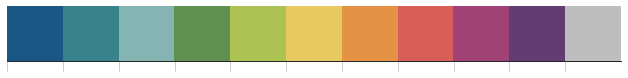

In [89]:
# Define rainbow color palette
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71','#BEBEBE']
sns.palplot(sns.color_palette(colors))

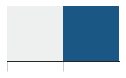

In [90]:
# Define gradient color
gradient = ['#EEEFEF','#1A5784']

cm = LinearSegmentedColormap.from_list(
        "Custom", gradient, N=100)

sns.palplot(sns.color_palette(gradient))

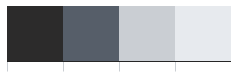

In [91]:
# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

In [92]:
# Define constants
figure_size = (16,9)

# # Define x-axis range
# left = dt.date(2005, 1, 1)
# right = dt.date(2023, 9, 1)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.2

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 24

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = -35
plt.rcParams["ytick.minor.pad"] = -35
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 24


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 28}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.7

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125

# Set axis labels
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.labelcolor'] = chart[1]

## 1. What was funded globally?


### Core capacities technical areas
- Global capacity funding
- Core capacities
- 2016-2022

#### Cleaning

In [125]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Core capacities over time (capacity funding)/results/Core capacities over time__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')
raw = raw.drop(columns=["Total disbursed post-2013 for capacity (nominal USD)","Percentage of total distributed to this capacity in year"])

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

df = df[df['Core capacity code'] != "Unspecified"]
df = df[df['Core capacity code'] != "General IHR"]


# Show data
df.head()

,Core capacity,Core capacity code,Year,Amount disbursed for year for capacity (nominal USD),Date
12,Antimicrobial Resistance (AMR),P.3,2016,4.559669e+08,2016-01-01
13,Antimicrobial Resistance (AMR),P.3,2017,5.159066e+08,2017-01-01
14,Antimicrobial Resistance (AMR),P.3,2018,4.576564e+08,2018-01-01
15,Antimicrobial Resistance (AMR),P.3,2019,6.963680e+08,2019-01-01
16,Antimicrobial Resistance (AMR),P.3,2020,8.985932e+08,2020-01-01


In [126]:
# Pivot the DataFrame with species as columns
pivot_df = df.pivot_table(index='Date', columns='Core capacity code', values='Amount disbursed for year for capacity (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
pivot_df.reset_index(inplace=True)

pivot_df.head()

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,P.5,P.6,P.7,PoE,R.1,R.2,R.3,R.4,R.5,RE
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.897295e+09,1.750387e+06,4.559669e+08,9.683955e+08,5.568938e+08,1.649790e+08,4.124724e+09,1.747628e+08,3.959728e+08,1.253705e+09,2.195465e+07,3.714145e+08,2.280237e+08,5.663598e+06
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.863829e+09,5.072462e+06,5.159066e+08,7.353843e+08,5.894185e+08,1.485413e+08,4.395565e+09,2.353514e+08,4.620758e+08,3.226662e+09,2.505217e+07,1.869246e+09,2.751574e+08,2.867588e+06
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.808810e+09,5.366373e+06,4.576564e+08,8.949415e+08,5.517190e+08,1.673508e+08,4.531361e+09,3.096061e+08,4.850936e+08,3.518560e+09,2.224941e+07,2.473196e+09,2.838208e+08,3.251511e+06
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,2.550778e+09,4.408997e+06,6.963680e+08,8.457247e+08,3.571130e+08,1.601567e+08,4.929810e+09,3.996439e+08,6.141263e+08,3.363920e+09,4.773422e+07,2.877631e+09,2.869748e+08,3.211831e+06
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,2.180065e+09,1.888991e+06,8.985932e+08,9.973695e+08,2.946363e+08,1.303716e+08,4.547082e+09,4.072928e+08,9.405529e+08,4.349224e+09,3.851696e+07,2.814755e+09,2.979341e+08,8.549597e+06


In [127]:
# Calculate total for each row
pivot_df['Total'] = pivot_df.sum(axis=1)


In [128]:
pivot_df.head()

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,P.6,P.7,PoE,R.1,R.2,R.3,R.4,R.5,RE,Total
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.897295e+09,1.750387e+06,4.559669e+08,9.683955e+08,...,1.649790e+08,4.124724e+09,1.747628e+08,3.959728e+08,1.253705e+09,2.195465e+07,3.714145e+08,2.280237e+08,5.663598e+06,1.928726e+10
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.863829e+09,5.072462e+06,5.159066e+08,7.353843e+08,...,1.485413e+08,4.395565e+09,2.353514e+08,4.620758e+08,3.226662e+09,2.505217e+07,1.869246e+09,2.751574e+08,2.867588e+06,2.348874e+10
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.808810e+09,5.366373e+06,4.576564e+08,8.949415e+08,...,1.673508e+08,4.531361e+09,3.096061e+08,4.850936e+08,3.518560e+09,2.224941e+07,2.473196e+09,2.838208e+08,3.251511e+06,2.441441e+10
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,2.550778e+09,4.408997e+06,6.963680e+08,8.457247e+08,...,1.601567e+08,4.929810e+09,3.996439e+08,6.141263e+08,3.363920e+09,4.773422e+07,2.877631e+09,2.869748e+08,3.211831e+06,2.888285e+10
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,2.180065e+09,1.888991e+06,8.985932e+08,9.973695e+08,...,1.303716e+08,4.547082e+09,4.072928e+08,9.405529e+08,4.349224e+09,3.851696e+07,2.814755e+09,2.979341e+08,8.549597e+06,3.043742e+10


In [129]:
# Assuming df is your DataFrame
sums = pivot_df.sum(axis=0)
top5_columns = sums.nlargest(6)

print("Top 5 columns with the largest sum:")
print(top5_columns)

Top 5 columns with the largest sum:
Core capacity code
Total    1.658058e+11
P.7      3.116735e+10
R.2      2.078700e+10
D.4      1.832145e+10
D.2      1.818639e+10
D.3      1.514769e+10
dtype: float64


#### Percent change

In [130]:
# Set 'Date' as the index
yearly_change = pivot_df.copy()

yearly_change.set_index('Date', inplace=True)

# Calculate the percentage change for each column
yearly_change = yearly_change.pct_change() * 100

# Reset index if you want 'Date' as a column again
yearly_change.reset_index(inplace=True)

# Display the DataFrame with percentage changes
yearly_change

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,P.6,P.7,PoE,R.1,R.2,R.3,R.4,R.5,RE,Total
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,39.287973,22.007558,8.874779,22.240367,-16.443306,-1.763864,189.790933,13.145626,-24.061572,...,-9.963510,6.566281,34.669028,16.693823,157.370082,14.108750,403.277717,20.670535,-49.368086,21.783659
2,2018-01-01,15.848563,-8.781228,1.063289,-6.148806,2.015401,-2.951964,5.794238,-11.290849,21.697124,...,12.662799,3.089370,31.550549,4.981377,9.046457,-11.187724,32.309780,3.148518,13.388360,3.940907
3,2019-01-01,-44.286169,43.859443,25.894386,24.697138,36.073008,41.019702,-17.840282,52.159563,-5.499450,...,-4.298781,8.793154,29.081401,26.599566,-4.394971,114.541539,16.352762,1.111240,-1.220355,18.302507
4,2020-01-01,-81.740810,16.656824,21.192058,-2.590487,-4.991567,-14.533327,-57.155996,29.040003,17.930761,...,-18.597486,-7.763548,1.913935,53.152992,29.290336,-19.309548,-2.185006,3.818910,166.190765,5.382303
5,2021-01-01,-17.273821,-3.319257,5.719599,-10.199993,-10.935435,-25.848754,-49.409103,19.334209,2.574355,...,-45.095070,-11.169288,11.340807,-6.689259,-9.842989,-5.047926,-24.862705,13.593131,13.126781,-8.839487
6,2022-01-01,-100.000000,-72.508163,-68.337000,-75.116445,-86.743621,-72.922877,-40.976498,-74.105352,-51.758779,...,-10.164611,13.873869,-79.669081,-74.016199,-70.574877,-83.578317,-49.615987,-73.219504,-57.473093,-58.380026


In [131]:
total_change = pivot_df.copy()

total_change.set_index('Date', inplace=True)

# Select the first and last rows
first_row = total_change.iloc[0]
last_row = total_change.iloc[-1]

# Calculate the percentage change between the first and last row
total_change = ((last_row - first_row) / first_row) * 100

# Display the percentage change
total_change


Core capacity code
CE      -100.000000
D.1      -50.356406
D.2      -43.803559
D.3      -68.861256
D.4      -86.988991
P.1      -76.929575
P.2      -67.774983
P.3      -39.101756
P.4      -49.036360
P.5      -88.053161
P.6      -61.022572
P.7       11.512891
PoE      -47.244345
R.1      -42.409327
R.2       -7.968986
R.3      -72.644314
R.4      186.899694
R.5      -60.252408
RE       -27.375611
Total    -40.124974
dtype: float64

#### Stacked bar chart

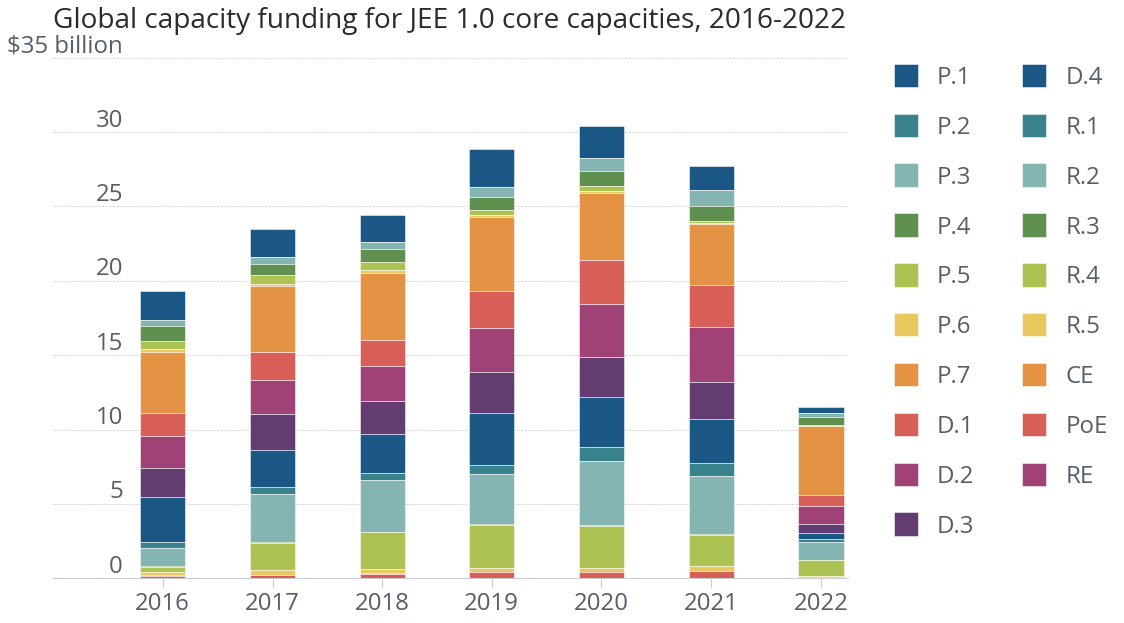

In [237]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=pivot_df['P.1']
y2=pivot_df['P.2']
y3=pivot_df['P.3']
y4=pivot_df['P.4']
y5=pivot_df['P.5']
y6=pivot_df['P.6']
y7=pivot_df['P.7']
y8= pivot_df['D.1']
y9 = pivot_df['D.2']
y10 =pivot_df['D.3']
y11 =pivot_df['D.4']
y12 =pivot_df['R.1']
y13 =pivot_df['R.2']
y14 =pivot_df['R.3']
y15 =pivot_df['R.4']
y16 =pivot_df['R.5']
y17 =pivot_df['CE']
y18 =pivot_df['PoE']
y19 =pivot_df['RE']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='P.1')
plt.bar(x, y2, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='P.2')
plt.bar(x, y3, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='P.3')
plt.bar(x, y4, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='P.4')
plt.bar(x, y5, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='P.5')
plt.bar(x, y6, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='P.6')
plt.bar(x, y7, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='P.7')
plt.bar(x, y8, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='D.1')
plt.bar(x, y9, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='D.2')
plt.bar(x, y10, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='D.3')
plt.bar(x, y11, bottom=y19+y18+y17+y16+y15+y14+y13+y12, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='D.4')
plt.bar(x, y12, bottom=y19+y18+y17+y16+y15+y14+y13, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='R.1')
plt.bar(x, y13, bottom=y19+y18+y17+y16+y15+y14, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='R.2')
plt.bar(x, y14, bottom=y19+y18+y17+y16+y15, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='R.3')
plt.bar(x, y15, bottom=y19+y18+y17+y16, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='R.4')
plt.bar(x, y16, bottom=y19+y18+y17, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='R.5')
plt.bar(x, y17, bottom=y19+y18, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='CE')
plt.bar(x, y18, bottom=y19, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='PoE')
plt.bar(x, y19, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='RE')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,35e9)

# Set title
title = "Global capacity funding for JEE 1.0 core capacities, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 7 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=2)


plt.tight_layout()
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/no_unspecified_global_core_capacity_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

In [229]:
# Load data
disb = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Disbursed capacity by year/results/disbursed_capacity_by_year.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
disb['Year'] = pd.to_datetime(disb['Year'], format='%Y').dt.year
disb['Date'] = pd.to_datetime(disb['Year'].astype(str) + '-01-01')

In [230]:
disb.head()

,Year,Total Disbursed,Date
0,2016,10423004841,2016-01-01
1,2017,12327371849,2017-01-01
2,2018,12196388317,2018-01-01
3,2019,14633276793,2019-01-01
4,2020,15233027511,2020-01-01


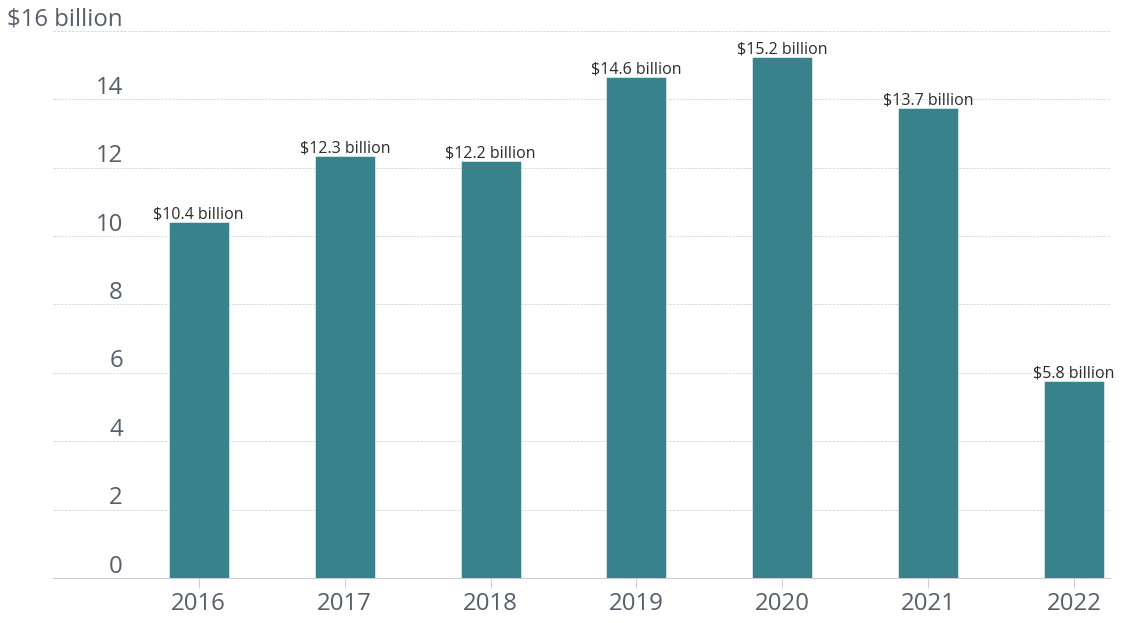

In [236]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=disb['Date']
y=disb['Total Disbursed']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
bars = plt.bar(x, y, linewidth=0.5, width=bar_width, align="center", color='#38828C')

# Annotate y-values on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             '${:,.1f} billion'.format((bar.get_height()/1e9)),
             ha='center', va='bottom', fontsize=16, color=chart[0])

# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,16e9)

# # Set title
# title = "Global preparedness funding, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left',pad=50)

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


plt.tight_layout()
# # plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/recolor_size_nounspec_global_core_capacity_total_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### Area chart

In [132]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# y_values = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21]
# reversed_y_values = [y21, y20, y19, y18, y17, y16, y15, y14, y13, y12, y11, y10, y9, y8, y7, y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# reversed_labels = ['Unspecified', 'General IHR', 'RE', 'PoE', 'CE', 'R.5', 'R.4', 'R.3', 'R.2', 'R.1', 'D.4', 'D.3', 'D.2', 'D.1', 'P.7', 'P.6', 'P.5', 'P.4', 'P.3', 'P.2', 'P.1']
# labels = ['P.1', 'P.2', 'P.3', 'P.4', 'P.5', 'P.6', 'P.7', 'D.1', 'D.2', 'D.3', 'D.4', 'R.1', 'R.2', 'R.3', 'R.4', 'R.5', 'CE', 'PoE', 'RE', 'General IHR', 'Unspecified']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = colors, labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,60e9)

# # Set title
# title = "Global capacity funding for JEE 1.0 core capacities, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.13,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_area_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait',bbox_inches='tight')

#### Relative proportions

In [133]:
# Extract the columns you want to calculate proportions for
columns_to_calculate = ['CE', 'D.1', 'D.2', 'D.3', 'D.4','P.1', 'P.2', 'P.3', 'P.4', 'P.5', 'P.6', 'P.7', 'PoE', 'R.1', 'R.2', 'R.3', 'R.4', 'R.5', 'RE']

relative_proportions = pivot_df.reset_index()

# Calculate relative proportions for each column for each year
relative_proportions = relative_proportions.groupby('Date')[columns_to_calculate].apply(lambda x: x.div(x.sum(axis=1), axis=0) * 100)

relative_proportions['Date'] = pd.to_datetime(['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01','2021-01-01','2022-01-01'])

relative_proportions

Core capacity code,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,P.5,P.6,P.7,PoE,R.1,R.2,R.3,R.4,R.5,RE,Date
0,0.043154,8.112869,10.977076,10.125345,15.671529,9.837034,0.009075,2.364083,5.020906,2.887365,0.855378,21.385740,0.906105,2.053027,6.500170,0.113830,1.925698,1.182250,0.029364,2016-01-01
1,0.049357,8.127785,9.813523,10.163316,10.752355,7.934991,0.021595,2.196400,3.130795,2.509367,0.632394,18.713502,1.001976,1.967223,13.737059,0.106656,7.958054,1.171444,0.012208,2017-01-01
2,0.055011,7.132962,9.541834,9.176747,10.553168,7.408780,0.021980,1.874534,3.665629,2.259809,0.685459,18.560192,1.268129,1.986915,14.411820,0.091132,10.130067,1.162514,0.013318,2018-01-01
3,0.025907,8.673899,10.154166,9.672779,12.138384,8.831461,0.015265,2.411008,2.928120,1.236419,0.554504,17.068293,1.383672,2.126266,11.646773,0.165268,9.963113,0.993582,0.011120,2019-01-01
4,0.004489,9.601892,11.677523,8.940977,10.943478,7.162451,0.006206,2.952265,3.276788,0.968007,0.428327,14.939119,1.338132,3.090121,14.289071,0.126545,9.247680,0.978841,0.028089,2020-01-01
5,0.004074,10.183335,13.542520,8.807539,10.691867,5.826038,0.003444,3.864680,3.687061,0.636407,0.257976,14.557318,1.634356,3.163008,14.131775,0.131808,7.622222,1.219713,0.034858,2021-01-01
6,0.000000,6.726544,10.302669,5.265810,3.405467,3.790304,0.004884,2.404483,4.273629,0.576115,0.556834,39.829390,0.798366,1.974700,9.991098,0.052007,9.227256,0.784828,0.035617,2022-01-01


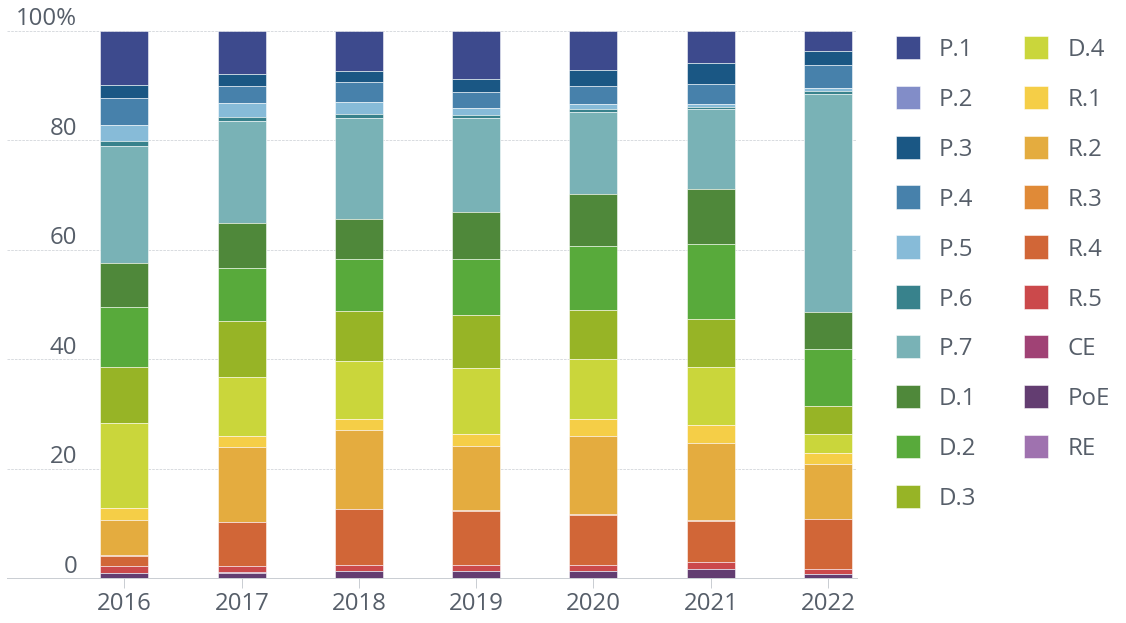

In [136]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=relative_proportions['Date']
y1=relative_proportions['P.1']
y2=relative_proportions['P.2']
y3=relative_proportions['P.3']
y4=relative_proportions['P.4']
y5=relative_proportions['P.5']
y6=relative_proportions['P.6']
y7=relative_proportions['P.7']
y8= relative_proportions['D.1']
y9 = relative_proportions['D.2']
y10 =relative_proportions['D.3']
y11 =relative_proportions['D.4']
y12 =relative_proportions['R.1']
y13 =relative_proportions['R.2']
y14 =relative_proportions['R.3']
y15 =relative_proportions['R.4']
y16 =relative_proportions['R.5']
y17 =relative_proportions['CE']
y18 =relative_proportions['PoE']
y19 =relative_proportions['RE']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color='#3D4A8D', label='P.1')
plt.bar(x, y2, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color='#828DC8', label='P.2')
plt.bar(x, y3, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.3')
plt.bar(x, y4, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color='#4781AB', label='P.4')
plt.bar(x, y5, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6, linewidth=0.5, width=bar_width, align="center", color='#87BBD8', label='P.5')
plt.bar(x, y6, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7, linewidth=0.5, width=bar_width, align="center", color='#38828C', label='P.6')
plt.bar(x, y7, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8, linewidth=0.5, width=bar_width, align="center", color='#79B2B6', label='P.7')
plt.bar(x, y8, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9, linewidth=0.5, width=bar_width, align="center", color='#4F883A', label='D.1')
plt.bar(x, y9, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10, linewidth=0.5, width=bar_width, align="center", color='#58AA3B', label='D.2')
plt.bar(x, y10, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11, linewidth=0.5, width=bar_width, align="center", color='#97B426', label='D.3')
plt.bar(x, y11, bottom=y19+y18+y17+y16+y15+y14+y13+y12, linewidth=0.5, width=bar_width, align="center", color='#CAD63B', label='D.4')
plt.bar(x, y12, bottom=y19+y18+y17+y16+y15+y14+y13, linewidth=0.5, width=bar_width, align="center", color='#F5CE47', label='R.1')
plt.bar(x, y13, bottom=y19+y18+y17+y16+y15+y14, linewidth=0.5, width=bar_width, align="center", color='#E4AC3F', label='R.2')
plt.bar(x, y14, bottom=y19+y18+y17+y16+y15, linewidth=0.5, width=bar_width, align="center", color='#E08A37', label='R.3')
plt.bar(x, y15, bottom=y19+y18+y17+y16, linewidth=0.5, width=bar_width, align="center", color='#D16637', label='R.4')
plt.bar(x, y16, bottom=y19+y18+y17, linewidth=0.5, width=bar_width, align="center", color='#CB494B', label='R.5')
plt.bar(x, y17, bottom=y19+y18, linewidth=0.5, width=bar_width, align="center", color='#A04275', label='CE')
plt.bar(x, y18, bottom=y19, linewidth=0.5, width=bar_width, align="center", color='#633D71', label='PoE')
plt.bar(x, y19, bottom=0, linewidth=0.5, width=bar_width, align="center", color='#9F72AF', label='RE')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = ""
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02,1.03),labelcolor=chart[1],labelspacing=1,ncol=2)


plt.tight_layout()
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/no_unspecified_global_core_capacity_relative_2016-22_recolor_bigleg.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

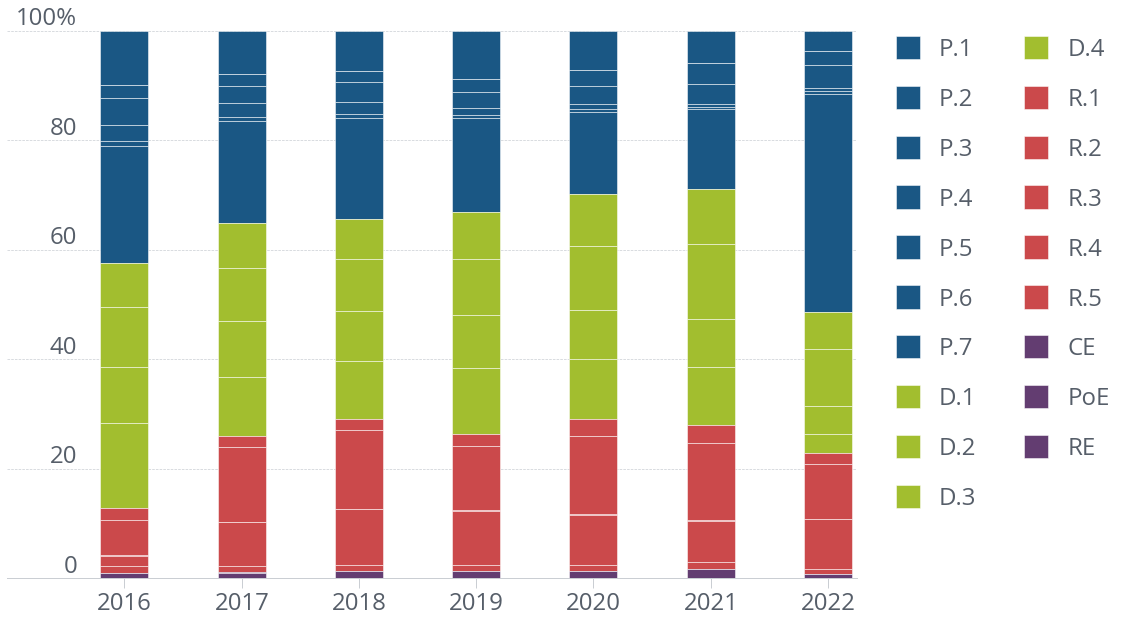

In [212]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=relative_proportions['Date']
y1=relative_proportions['P.1']
y2=relative_proportions['P.2']
y3=relative_proportions['P.3']
y4=relative_proportions['P.4']
y5=relative_proportions['P.5']
y6=relative_proportions['P.6']
y7=relative_proportions['P.7']
y8= relative_proportions['D.1']
y9 = relative_proportions['D.2']
y10 =relative_proportions['D.3']
y11 =relative_proportions['D.4']
y12 =relative_proportions['R.1']
y13 =relative_proportions['R.2']
y14 =relative_proportions['R.3']
y15 =relative_proportions['R.4']
y16 =relative_proportions['R.5']
y17 =relative_proportions['CE']
y18 =relative_proportions['PoE']
y19 =relative_proportions['RE']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.1')
plt.bar(x, y2, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.2')
plt.bar(x, y3, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.3')
plt.bar(x, y4, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.4')
plt.bar(x, y5, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.5')
plt.bar(x, y6, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.6')
plt.bar(x, y7, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='P.7')
plt.bar(x, y8, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9, linewidth=0.5, width=bar_width, align="center", color='#A2BE2F', label='D.1')
plt.bar(x, y9, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11+y10, linewidth=0.5, width=bar_width, align="center", color='#A2BE2F', label='D.2')
plt.bar(x, y10, bottom=y19+y18+y17+y16+y15+y14+y13+y12+y11, linewidth=0.5, width=bar_width, align="center", color='#A2BE2F', label='D.3')
plt.bar(x, y11, bottom=y19+y18+y17+y16+y15+y14+y13+y12, linewidth=0.5, width=bar_width, align="center", color='#A2BE2F', label='D.4')
plt.bar(x, y12, bottom=y19+y18+y17+y16+y15+y14+y13, linewidth=0.5, width=bar_width, align="center", color='#CB494B', label='R.1')
plt.bar(x, y13, bottom=y19+y18+y17+y16+y15+y14, linewidth=0.5, width=bar_width, align="center", color='#CB494B', label='R.2')
plt.bar(x, y14, bottom=y19+y18+y17+y16+y15, linewidth=0.5, width=bar_width, align="center", color='#CB494B', label='R.3')
plt.bar(x, y15, bottom=y19+y18+y17+y16, linewidth=0.5, width=bar_width, align="center", color='#CB494B', label='R.4')
plt.bar(x, y16, bottom=y19+y18+y17, linewidth=0.5, width=bar_width, align="center", color='#CB494B', label='R.5')
plt.bar(x, y17, bottom=y19+y18, linewidth=0.5, width=bar_width, align="center", color='#633D71', label='CE')
plt.bar(x, y18, bottom=y19, linewidth=0.5, width=bar_width, align="center", color='#633D71', label='PoE')
plt.bar(x, y19, bottom=0, linewidth=0.5, width=bar_width, align="center", color='#633D71', label='RE')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = ""
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02,1.03),labelcolor=chart[1],labelspacing=1,ncol=2)


plt.tight_layout()
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/no_unspecified_global_core_capacity_relative_2016-22_recolor_bigleg.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Major thematic areas (instead of capacities)
- Global capacity funding
- P, D, R
- 2016-2022

#### Cleaning

In [189]:
pivot_df['Prevent'] = pivot_df['P.1'] + pivot_df['P.2'] + pivot_df['P.3'] + pivot_df['P.4'] + pivot_df['P.5'] + pivot_df['P.6'] + pivot_df['P.7']
pivot_df['Detect'] = pivot_df['D.1'] + pivot_df['D.2'] + pivot_df['D.3'] + pivot_df['D.4']
pivot_df['Respond'] = pivot_df['R.1'] + pivot_df['R.2'] + pivot_df['R.3'] + pivot_df['R.4'] + pivot_df['R.5'] 
pivot_df['IHR Related Hazards'] = pivot_df['CE'] + pivot_df['RE'] + pivot_df['PoE']
# pivot_df['Not specified'] = pivot_df['General IHR'] + pivot_df['Unspecified']

In [190]:
# Calculate percentages for each category
pivot_df['Prevent (%)'] = (pivot_df['Prevent'] / pivot_df['Total']) * 100
pivot_df['Detect (%)'] = (pivot_df['Detect'] / pivot_df['Total']) * 100
pivot_df['Respond (%)'] = (pivot_df['Respond'] / pivot_df['Total']) * 100
pivot_df['IHR Related Hazards (%)'] = (pivot_df['IHR Related Hazards'] / pivot_df['Total']) * 100
# pivot_df['Not specified (%)'] = (pivot_df['Not specified'] / pivot_df['Total']) * 100

# Calculate the average for each column
average_values = pivot_df[['Prevent (%)', 'Detect (%)', 'Respond (%)', 'IHR Related Hazards (%)']].mean()
# average_values = pivot_df[['Prevent (%)', 'Detect (%)', 'Respond (%)', 'IHR Related Hazards (%)']].mean()


# Display the average values
print(average_values)

Core capacity code
Prevent (%)                36.431687
Detect (%)                 38.696765
Respond (%)                23.631933
IHR Related Hazards (%)     1.239614
dtype: float64


In [191]:
pivot_df

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,RE,Total,Prevent,Detect,Respond,IHR Related Hazards,Prevent (%),Detect (%),Respond (%),IHR Related Hazards (%)
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.897295e+09,1.750387e+06,4.559669e+08,9.683955e+08,...,5.663598e+06,1.928726e+10,8.170005e+09,8.657440e+09,2.271071e+09,1.887497e+08,42.359582,44.886819,11.774975,0.978624
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.863829e+09,5.072462e+06,5.159066e+08,7.353843e+08,...,2.867588e+06,2.348874e+10,8.253718e+09,9.127013e+09,5.858193e+09,2.498124e+08,35.139044,38.856979,24.940436,1.063541
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.808810e+09,5.366373e+06,4.576564e+08,8.949415e+08,...,3.251511e+06,2.441441e+10,8.417204e+09,8.887994e+09,6.782920e+09,3.262883e+08,34.476384,36.404710,27.782448,1.336458
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,2.550778e+09,4.408997e+06,6.963680e+08,8.457247e+08,...,3.211831e+06,2.888285e+10,9.544359e+09,1.173777e+10,7.190387e+09,4.103385e+08,33.045070,40.639229,24.895002,1.420699
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,2.180065e+09,1.888991e+06,8.985932e+08,9.973695e+08,...,8.549597e+06,3.043742e+10,9.050007e+09,1.252922e+10,8.440983e+09,4.172087e+08,29.733162,41.163870,27.732258,1.370710
5,2021-01-01,1.130282e+06,2.825560e+09,3.757630e+09,2.443819e+09,2.966662e+09,1.616545e+09,9.556573e+05,1.072329e+09,1.023045e+09,...,9.671884e+06,2.774691e+10,8.000245e+09,1.199367e+10,7.288703e+09,4.642853e+08,28.832925,43.225261,26.268527,1.673287
6,2022-01-01,0.000000e+00,7.767984e+08,1.189778e+09,6.081092e+08,3.932720e+08,4.377140e+08,5.640624e+05,2.776758e+08,4.935296e+08,...,4.113153e+06,1.154825e+10,5.939919e+09,2.967958e+09,2.544068e+09,9.631044e+07,51.435639,25.700490,22.029888,0.833983


#### Stacked bar chart

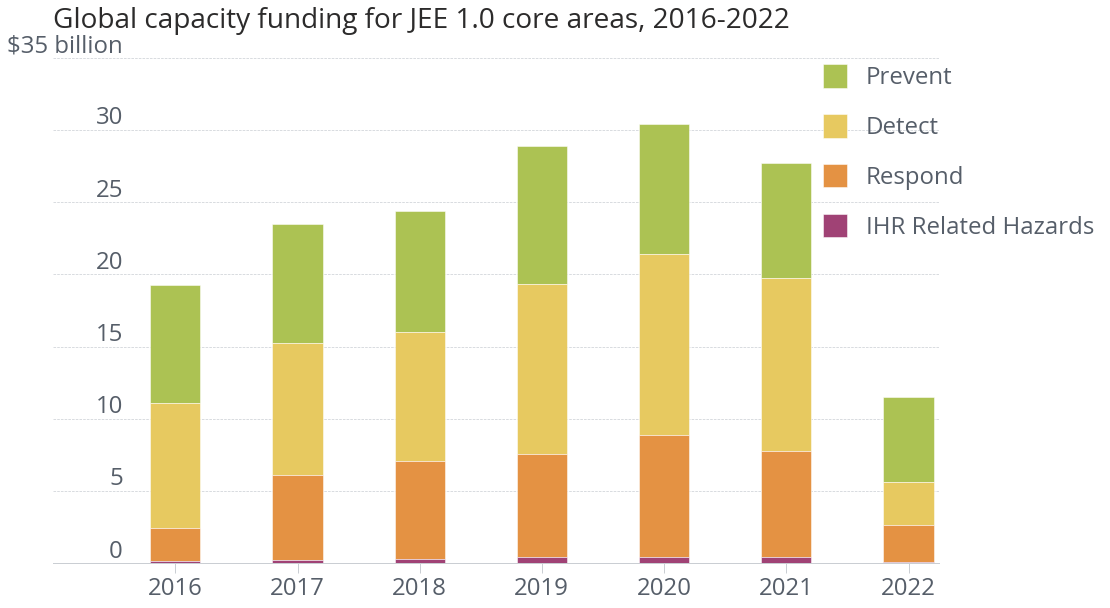

In [104]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=pivot_df['Prevent'] 
y2=pivot_df['Detect']
y3=pivot_df['Respond']
y4=pivot_df['IHR Related Hazards']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Prevent')
plt.bar(x, y2, bottom=y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Detect')
plt.bar(x, y3, bottom=y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Respond')
plt.bar(x, y4, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='IHR Related Hazards')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,35e9)

# Set title
title = "Global capacity funding for JEE 1.0 core areas, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 7 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.2,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/no_unspecified_global_core_areas_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

#### Area chart

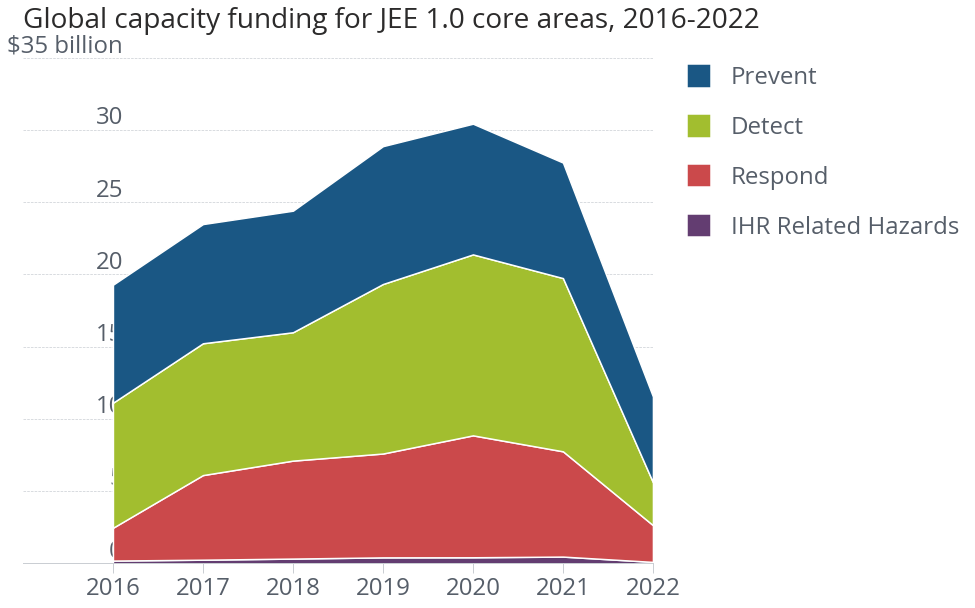

In [211]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['Prevent','Detect','Respond','IHR Related Hazards']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = ['633D71','CB494B','A2BE2F','1A5784'], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,35e9)

# # Set title
# title = "Global capacity funding for JEE 1.0 core areas, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 7 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.52,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_area_area_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

In [108]:
# pivot_df.head()

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,Unspecified,Total,Prevent,Detect,Respond,IHR Related Hazards,Prevent (%),Detect (%),Respond (%),IHR Related Hazards (%)
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.897295e+09,1.750387e+06,4.559669e+08,9.683955e+08,...,1.611291e+10,3.540017e+10,8.170005e+09,8.657440e+09,2.271071e+09,1.887497e+08,23.078998,24.455926,6.415423,0.533189
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.863829e+09,5.072462e+06,5.159066e+08,7.353843e+08,...,1.629000e+10,3.977874e+10,8.253718e+09,9.127013e+09,5.858193e+09,2.498124e+08,20.749067,22.944451,14.726945,0.628005
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.808810e+09,5.366373e+06,4.576564e+08,8.949415e+08,...,1.654665e+10,4.096106e+10,8.417204e+09,8.887994e+09,6.782920e+09,3.262883e+08,20.549286,21.698645,16.559436,0.796582
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,2.550778e+09,4.408997e+06,6.963680e+08,8.457247e+08,...,1.774827e+10,4.663112e+10,9.544359e+09,1.173777e+10,7.190387e+09,4.103385e+08,20.467787,25.171534,15.419717,0.879967
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,2.180065e+09,1.888991e+06,8.985932e+08,9.973695e+08,...,2.531765e+10,5.575507e+10,9.050007e+09,1.252922e+10,8.440983e+09,4.172087e+08,16.231720,22.471892,15.139401,0.748288


#### Relative proportion

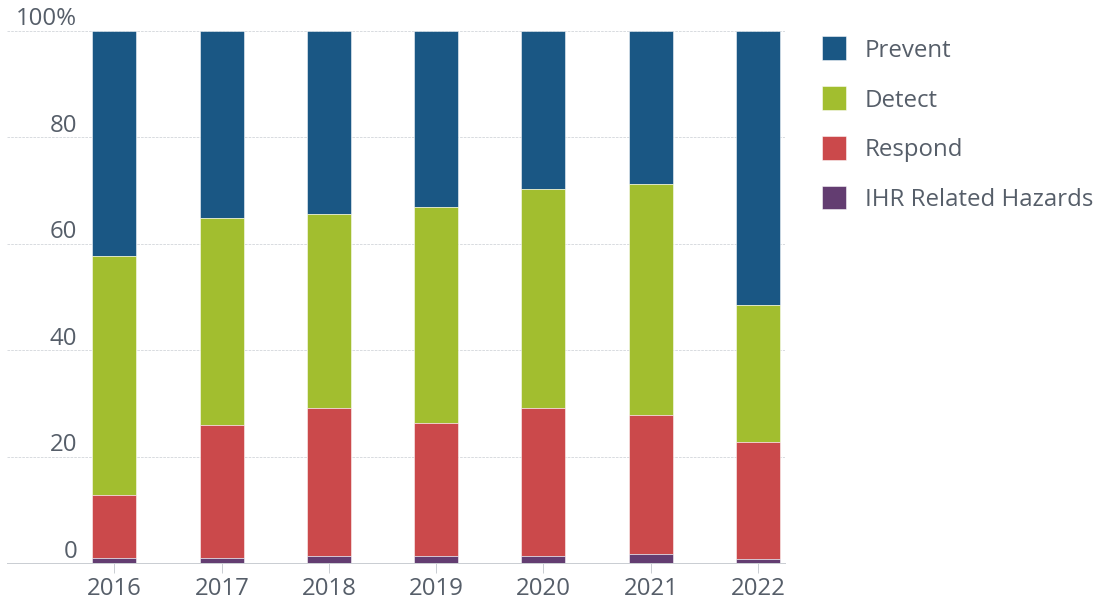

In [187]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=pivot_df['Prevent (%)'] 
y2=pivot_df['Detect (%)']
y3=pivot_df['Respond (%)']
y4=pivot_df['IHR Related Hazards (%)']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color='#1A5784', label='Prevent')
plt.bar(x, y2, bottom=y4+y3, linewidth=0.5, width=bar_width, align="center", color='#A2BE2F', label='Detect')
plt.bar(x, y3, bottom=y4, linewidth=0.5, width=bar_width, align="center", color='#CB494B', label='Respond')
plt.bar(x, y4, bottom=0, linewidth=0.5, width=bar_width, align="center", color='#633D71', label='IHR Related Hazards')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = ""
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/no_unspecified_global_core_areas_relative_2016-22_recolor_bigleg.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

In [57]:
pivot_df

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,Unspecified,Total,Prevent,Detect,Respond,IHR Related Hazards,Prevent (%),Detect (%),Respond (%),IHR Related Hazards (%)
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.897295e+09,1.750387e+06,4.559669e+08,9.683955e+08,...,1.611291e+10,3.540017e+10,8.170005e+09,8.657440e+09,2.271071e+09,1.887497e+08,23.078998,24.455926,6.415423,0.533189
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.863829e+09,5.072462e+06,5.159066e+08,7.353843e+08,...,1.629000e+10,3.977874e+10,8.253718e+09,9.127013e+09,5.858193e+09,2.498124e+08,20.749067,22.944451,14.726945,0.628005
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.808810e+09,5.366373e+06,4.576564e+08,8.949415e+08,...,1.654665e+10,4.096106e+10,8.417204e+09,8.887994e+09,6.782920e+09,3.262883e+08,20.549286,21.698645,16.559436,0.796582
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,2.550778e+09,4.408997e+06,6.963680e+08,8.457247e+08,...,1.774827e+10,4.663112e+10,9.544359e+09,1.173777e+10,7.190387e+09,4.103385e+08,20.467787,25.171534,15.419717,0.879967
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,2.180065e+09,1.888991e+06,8.985932e+08,9.973695e+08,...,2.531765e+10,5.575507e+10,9.050007e+09,1.252922e+10,8.440983e+09,4.172087e+08,16.231720,22.471892,15.139401,0.748288
5,2021-01-01,1.130282e+06,2.825560e+09,3.757630e+09,2.443819e+09,2.966662e+09,1.616545e+09,9.556573e+05,1.072329e+09,1.023045e+09,...,2.317570e+10,5.092260e+10,8.000245e+09,1.199367e+10,7.288703e+09,4.642853e+08,15.710596,23.552747,14.313296,0.911747
6,2022-01-01,0.000000e+00,7.767984e+08,1.189778e+09,6.081092e+08,3.932720e+08,4.377140e+08,5.640624e+05,2.776758e+08,4.935296e+08,...,4.762266e+09,1.631052e+10,5.939919e+09,2.967958e+09,2.544068e+09,9.631044e+07,36.417714,18.196587,15.597710,0.590480


#### Percent change

In [139]:
# Set 'Date' as the index
yearly_change = pivot_df.copy()

yearly_change.set_index('Date', inplace=True)

# Calculate the percentage change for each column
yearly_change = yearly_change.pct_change() * 100

# Reset index if you want 'Date' as a column again
yearly_change.reset_index(inplace=True)

# Display the DataFrame with percentage changes
yearly_change

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,RE,Total,Prevent,Detect,Respond,IHR Related Hazards,Prevent (%),Detect (%),Respond (%),IHR Related Hazards (%)
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,39.287973,22.007558,8.874779,22.240367,-16.443306,-1.763864,189.790933,13.145626,-24.061572,...,-49.368086,21.783659,1.024637,5.423935,157.948527,32.351104,-17.045819,-13.433431,111.808816,8.677227
2,2018-01-01,15.848563,-8.781228,1.063289,-6.148806,2.015401,-2.951964,5.794238,-11.290849,21.697124,...,13.388360,3.940907,1.980763,-2.618816,15.785179,30.613365,-1.885825,-6.311011,11.395198,25.661176
3,2019-01-01,-44.286169,43.859443,25.894386,24.697138,36.073008,41.019702,-17.840282,52.159563,-5.499450,...,-1.220355,18.302507,13.391087,32.063201,6.007260,25.759475,-4.151577,11.631786,-10.393056,6.303306
4,2020-01-01,-81.740810,16.656824,21.192058,-2.590487,-4.991567,-14.533327,-57.155996,29.040003,17.930761,...,166.190765,5.382303,-5.179528,6.742759,17.392606,1.674280,-10.022395,1.290972,11.396888,-3.518639
5,2021-01-01,-17.273821,-3.319257,5.719599,-10.199993,-10.935435,-25.848754,-49.409103,19.334209,2.574355,...,13.126781,-8.839487,-11.599572,-4.274379,-13.651013,11.283698,-3.027720,5.007769,-5.278081,22.074453
6,2022-01-01,-100.000000,-72.508163,-68.337000,-75.116445,-86.743621,-72.922877,-40.976498,-74.105352,-51.758779,...,-57.473093,-58.380026,-25.753287,-75.253967,-65.095745,-79.256194,78.392023,-40.542892,-16.135806,-50.159011


In [140]:
total_change = pivot_df.copy()

total_change.set_index('Date', inplace=True)

# Select the first and last rows
first_row = total_change.iloc[0]
last_row = total_change.iloc[-1]

# Calculate the percentage change between the first and last row
total_change = ((last_row - first_row) / first_row) * 100

# Display the percentage change
total_change


Core capacity code
CE                        -100.000000
D.1                        -50.356406
D.2                        -43.803559
D.3                        -68.861256
D.4                        -86.988991
P.1                        -76.929575
P.2                        -67.774983
P.3                        -39.101756
P.4                        -49.036360
P.5                        -88.053161
P.6                        -61.022572
P.7                         11.512891
PoE                        -47.244345
R.1                        -42.409327
R.2                         -7.968986
R.3                        -72.644314
R.4                        186.899694
R.5                        -60.252408
RE                         -27.375611
Total                      -40.124974
Prevent                    -27.296020
Detect                     -65.717831
Respond                     12.020628
IHR Related Hazards        -48.974531
Prevent (%)                 21.426219
Detect (%)                 -42.

### Integrated response funding
- Global capacity and response funding
- Core capacities and response
- 2016-2022

In [176]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Core capacities over time (response funding)/results/Core capacities over time (response funding)__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

# Show data
df.head()

,Core capacity,Core capacity code,Year,Amount disbursed for year for capacity (nominal USD),Date
0,Biosafety and Biosecurity,P.6,2017,712634.823125,2017-01-01
1,Biosafety and Biosecurity,P.6,2018,713374.578000,2018-01-01
2,Biosafety and Biosecurity,P.6,2019,696315.924100,2019-01-01
3,Biosafety and Biosecurity,P.6,2020,696315.924100,2020-01-01
4,Biosafety and Biosecurity,P.6,2021,696315.924100,2021-01-01


In [177]:
# Pivot the DataFrame with species as columns
response_pivot_df = df.pivot_table(index='Date', columns='Core capacity code', values='Amount disbursed for year for capacity (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
response_pivot_df.reset_index(inplace=True)

response_pivot_df['Total'] = response_pivot_df.sum(axis=1)

response_pivot_df

Core capacity code,Date,D.1,D.2,D.4,General IHR,P.1,P.4,P.6,P.7,PoE,R.1,R.2,R.4,R.5,Unspecified,Total
0,2016-01-01,0.000000e+00,1.500000e+08,1.873333e+05,198000,0.000000e+00,0.0000,0.000000,0.000000e+00,0,6.396075e+06,1.764189e+06,2.206667e+05,0,1.794616e+09,1.953382e+09
1,2017-01-01,0.000000e+00,1.797637e+05,0.000000e+00,0,0.000000e+00,0.0000,712634.823125,0.000000e+00,0,0.000000e+00,1.691132e+06,7.267591e+06,0,1.295563e+09,1.305414e+09
2,2018-01-01,0.000000e+00,1.517995e+07,0.000000e+00,0,0.000000e+00,360295.4424,713374.578000,0.000000e+00,0,0.000000e+00,7.133292e+07,7.275135e+06,0,9.822695e+08,1.077131e+09
3,2019-01-01,2.333333e+05,9.572148e+05,2.333333e+05,0,0.000000e+00,0.0000,696315.924100,0.000000e+00,0,8.620000e+06,0.000000e+00,7.101168e+06,0,1.834431e+09,1.852272e+09
4,2020-01-01,2.333333e+05,2.285721e+07,3.233333e+06,0,0.000000e+00,0.0000,696315.924100,1.422412e+09,3000000,1.803923e+09,1.803923e+09,8.983103e+06,0,2.612477e+10,3.119403e+10
5,2021-01-01,2.347770e+06,9.572148e+05,5.347770e+06,0,2.114436e+06,0.0000,696315.924100,0.000000e+00,3000000,1.498798e+09,1.498798e+09,8.983103e+06,0,3.986277e+10,4.288382e+10
6,2022-01-01,2.114436e+06,9.572148e+05,5.114436e+06,0,2.114436e+06,0.0000,696315.924100,0.000000e+00,3000000,0.000000e+00,0.000000e+00,7.101168e+06,1450000,6.811282e+09,6.833830e+09


In [178]:
pivot_df.head()

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,Unspecified,Total,Prevent,Detect,Respond,IHR Related Hazards,Prevent (%),Detect (%),Respond (%),IHR Related Hazards (%)
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.897295e+09,1.750387e+06,4.559669e+08,9.683955e+08,...,1.611291e+10,3.540017e+10,8.170005e+09,8.657440e+09,2.271071e+09,1.887497e+08,23.078998,24.455926,6.415423,0.533189
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.863829e+09,5.072462e+06,5.159066e+08,7.353843e+08,...,1.629000e+10,3.977874e+10,8.253718e+09,9.127013e+09,5.858193e+09,2.498124e+08,20.749067,22.944451,14.726945,0.628005
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.808810e+09,5.366373e+06,4.576564e+08,8.949415e+08,...,1.654665e+10,4.096106e+10,8.417204e+09,8.887994e+09,6.782920e+09,3.262883e+08,20.549286,21.698645,16.559436,0.796582
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,2.550778e+09,4.408997e+06,6.963680e+08,8.457247e+08,...,1.774827e+10,4.663112e+10,9.544359e+09,1.173777e+10,7.190387e+09,4.103385e+08,20.467787,25.171534,15.419717,0.879967
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,2.180065e+09,1.888991e+06,8.985932e+08,9.973695e+08,...,2.531765e+10,5.575507e+10,9.050007e+09,1.252922e+10,8.440983e+09,4.172087e+08,16.231720,22.471892,15.139401,0.748288


In [179]:
pivot_df['Response (%)'] =  (response_pivot_df['Total'] / (response_pivot_df['Total'] + pivot_df['Total'])) * 100

In [180]:
pivot_df['Total']

0    3.540017e+10
1    3.977874e+10
2    4.096106e+10
3    4.663112e+10
4    5.575507e+10
5    5.092260e+10
6    1.631052e+10
Name: Total, dtype: float64

#### Stacked bar chart

In [182]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=pivot_df['Date']
# y1=pivot_df['Prevent'] 
# y2=pivot_df['Detect']
# y3=pivot_df['Respond']
# y4=pivot_df['IHR Related Hazards']
# y5=pivot_df['Unspecified']
# y6 = response_pivot_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,100e9)

# # Set title
# title = "Global funding for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Area chart

In [183]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,100e9)

# # Set title
# title = "Global capacity funding for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Relative proportions

In [184]:
percentage_response = response_pivot_df['Total'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_prevent = pivot_df['Prevent'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_detect = pivot_df['Detect'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_respond = pivot_df['Respond'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_ihr = pivot_df['IHR Related Hazards'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_unknown = pivot_df['Unspecified'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100

# print(pivot_df['Prevent']+pivot_df['Detect']+pivot_df['Respond']+pivot_df['IHR Related Hazards'])
tot = response_pivot_df['Total'] + pivot_df['Total']
print(tot)


# All years
print(percentage_response)

# Calculate the average for each column
avg_percentage_response = percentage_response.mean()
avg_percentage_prevent = percentage_prevent.mean()
avg_percentage_detect = percentage_detect.mean()
avg_percentage_respond = percentage_respond.mean()
avg_percentage_ihr = percentage_ihr.mean()
avg_percentage_unknown = percentage_unknown.mean()

# Display the average values over all years
print("Average Percentage Response:", avg_percentage_response)
print("Average Percentage Prevent:", avg_percentage_prevent)
print("Average Percentage Detect:", avg_percentage_detect)
print("Average Percentage Respond:", avg_percentage_respond)
print("Average Percentage IHR:", avg_percentage_ihr)
print("Average Percentage Unknown:", avg_percentage_unknown)

0    3.735355e+10
1    4.108415e+10
2    4.203819e+10
3    4.848340e+10
4    8.694910e+10
5    9.380642e+10
6    2.314435e+10
Name: Total, dtype: float64
0     5.229442
1     3.177414
2     2.562268
3     3.820426
4    35.876197
5    45.715224
6    29.526990
Name: Total, dtype: float64
Average Percentage Response: 17.986851740143432
Average Percentage Prevent: 18.03885487907876
Average Percentage Detect: 18.68057706570218
Average Percentage Respond: 11.39639615595444
Average Percentage IHR: 0.5895394521585368
Average Percentage Unknown: 33.30778070696265


In [185]:
specified = percentage_prevent + percentage_detect + percentage_respond
unspecified = percentage_ihr + percentage_unknown
response = percentage_response

In [186]:
print(specified.mean())
print("--")
print(unspecified)
print("--")
print(response)



48.11582810073537
--
0    43.641514
1    40.258383
2    40.137168
3    37.453252
4    29.597615
5    25.200818
6    20.992493
dtype: float64
--
0     5.229442
1     3.177414
2     2.562268
3     3.820426
4    35.876197
5    45.715224
6    29.526990
Name: Total, dtype: float64


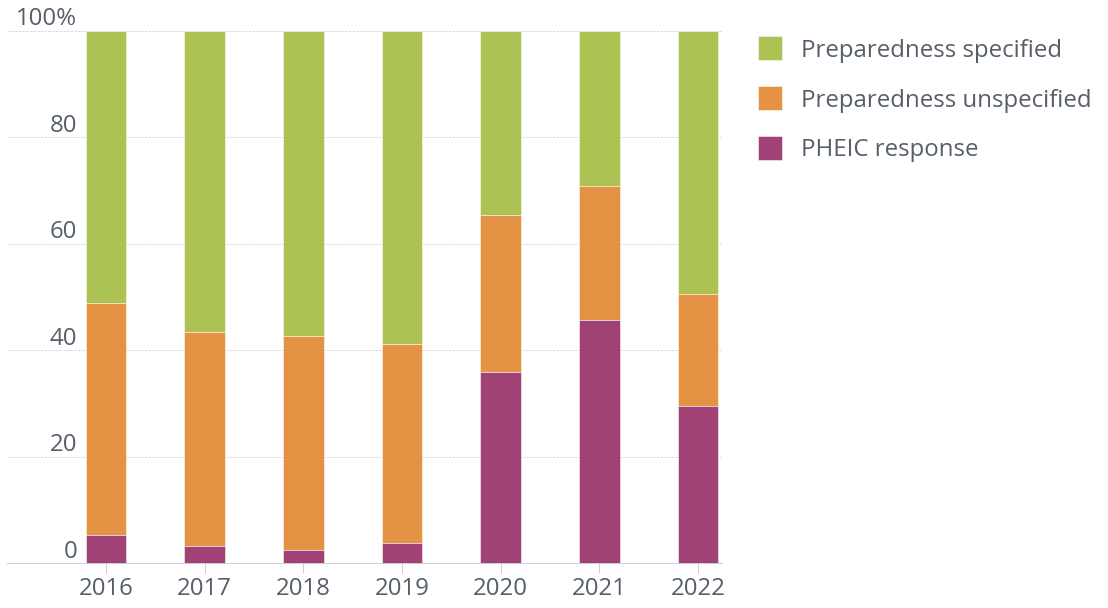

In [215]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=specified
y2=unspecified
y3=response



# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150

plt.bar(x, y1, bottom=y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Preparedness specified')
plt.bar(x, y2, bottom=y3, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Preparedness unspecified')
plt.bar(x, y3, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='PHEIC response')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = ""
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_relative_prep_and_response_2016-22_bigleg.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Specified vs. unspecified

In [32]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Core capacities over time (capacity funding)/results/Core capacities over time__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

# Show data
df.head()

,Core capacity,Core capacity code,Year,Amount disbursed for year for capacity (nominal USD),Total disbursed post-2013 for capacity (nominal USD),Percentage of total distributed to this capacity in year,Date
12,Antimicrobial Resistance (AMR),P.3,2016,4.559669e+08,6.225262e+09,7.32,2016-01-01
13,Antimicrobial Resistance (AMR),P.3,2017,5.159066e+08,6.225262e+09,8.29,2017-01-01
14,Antimicrobial Resistance (AMR),P.3,2018,4.576564e+08,6.225262e+09,7.35,2018-01-01
15,Antimicrobial Resistance (AMR),P.3,2019,6.963680e+08,6.225262e+09,11.19,2019-01-01
16,Antimicrobial Resistance (AMR),P.3,2020,8.985932e+08,6.225262e+09,14.43,2020-01-01


In [33]:
# Pivot the DataFrame with species as columns
pivot_df = df.pivot_table(index='Date', columns='Core capacity code', values='Amount disbursed for year for capacity (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
pivot_df.reset_index(inplace=True)

pivot_df['Total_Specified'] = pivot_df['P.1'] + pivot_df['P.2'] + pivot_df['P.3'] + pivot_df['P.4'] + pivot_df['P.5'] + pivot_df['P.6'] + pivot_df['P.7']+ pivot_df['D.1'] + pivot_df['D.2'] + pivot_df['D.3'] + pivot_df['D.4']+pivot_df['R.1'] + pivot_df['R.2'] + pivot_df['R.3'] + pivot_df['R.4'] + pivot_df['R.5'] + pivot_df['CE'] + pivot_df['RE'] + pivot_df['PoE']
pivot_df['Total_NotSpecified'] = pivot_df['General IHR'] + pivot_df['Unspecified']
pivot_df['Total'] = pivot_df['Total_Specified']+pivot_df['Total_NotSpecified']

#### Stacked bar chart

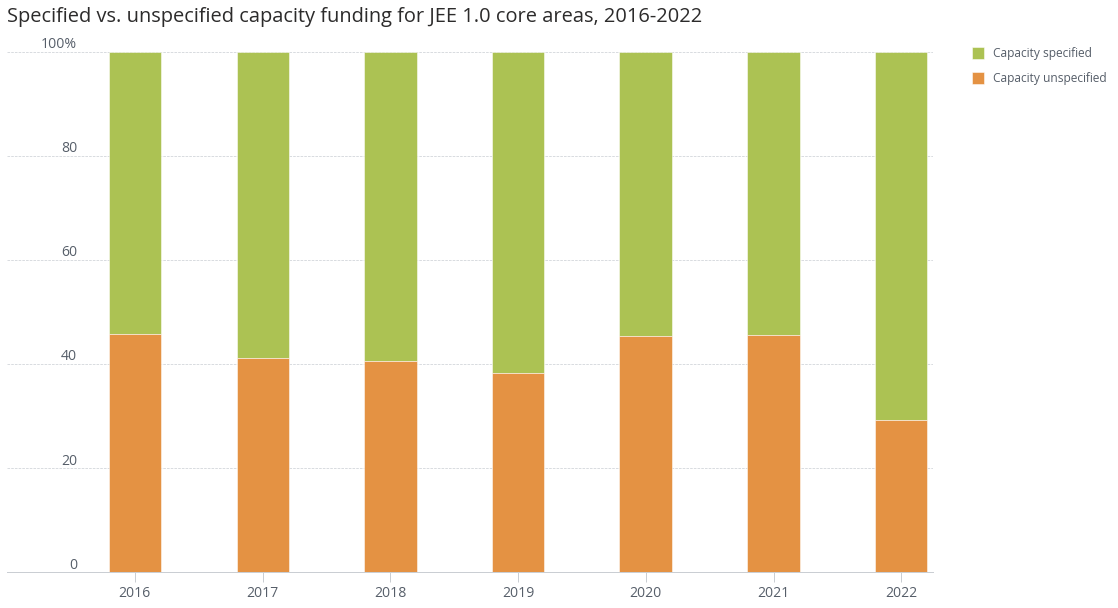

In [34]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=(pivot_df['Total_Specified']/pivot_df["Total"])*100
y2=(pivot_df['Total_NotSpecified']/pivot_df["Total"])*100



# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity specified')
plt.bar(x, y2, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity unspecified')

# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Specified vs. unspecified capacity funding for JEE 1.0 core areas, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if y== 100 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.2,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/specified_unspecified_capacity_funding_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

## 2. Who was funded for what?
- 2016-2022
- WHO Region recipients
- Core capacity funding 

### Cleaning

In [147]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Core capacity recipients by WHO region/results/Core capacity recipients by WHO region by year__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]
df = df[df['Core capacity code'] != "General IHR"]
df = df[df['Core capacity code'] != "Unspecified"]


df.head()


,Recipient WHO Region,Core capacity,Core capacity code,Total disbursed (nominal USD),Year,Date
1388,searo,Biosafety and Biosecurity,P.6,4.929424e+07,2016,2016-01-01
1389,NaN,Medical Countermeasures and Personnel Deployment,R.4,5.048242e+07,2016,2016-01-01
1390,amro,Real Time Surveillance,D.2,3.586856e+07,2016,2016-01-01
1391,wpro,Immunization,P.7,6.922977e+07,2016,2016-01-01
1392,searo,Preparedness,R.1,1.528094e+07,2016,2016-01-01


In [148]:
afro = df[df['Recipient WHO Region'] == 'afro']
amro = df[df['Recipient WHO Region'] == 'amro']
emro = df[df['Recipient WHO Region'] == 'emro']
euro = df[df['Recipient WHO Region'] == 'euro']
searo = df[df['Recipient WHO Region'] == 'searo']
wpro = df[df['Recipient WHO Region'] == 'wpro']

### AFRO

In [149]:
# Pivot the DataFrame with species as columns
afro_df = afro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
afro_df.reset_index(inplace=True)

# Calculate total for each row
afro_df['Total'] = afro_df.sum(axis=1)

afro_df['Prevent'] = afro_df['P.1'] + afro_df['P.2'] + afro_df['P.3'] + afro_df['P.4'] + afro_df['P.5'] + afro_df['P.6'] + afro_df['P.7']
afro_df['Detect'] = afro_df['D.1'] + afro_df['D.2'] + afro_df['D.3'] + afro_df['D.4']
afro_df['Respond'] = afro_df['R.1'] + afro_df['R.2'] + afro_df['R.3'] + afro_df['R.4'] + afro_df['R.5'] 
afro_df['IHR Related Hazards'] = afro_df['CE'] + afro_df['RE'] + afro_df['PoE']
# afro_df['Not specified'] = afro_df['General IHR'] + afro_df['Unspecified']

afro_df

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,P.1,P.2,P.3,P.4,...,R.2,R.3,R.4,R.5,RE,Total,Prevent,Detect,Respond,IHR Related Hazards
0,2016-01-01,2.837762e+06,7.054803e+08,8.603980e+08,1.211593e+09,9.132864e+08,6.244020e+08,0.000000,7.971098e+07,2.122826e+08,...,3.433935e+08,7.872479e+06,1.468265e+08,7.590315e+07,2.916790e+06,6.971394e+09,2.550513e+09,3.690757e+09,6.666667e+08,6.345756e+07
1,2017-01-01,0.000000e+00,9.282148e+08,9.210305e+08,1.461010e+09,1.163403e+09,5.706353e+08,0.000000,1.404032e+08,2.112734e+08,...,5.397021e+08,9.178285e+06,2.995128e+08,8.063012e+07,0.000000e+00,8.407725e+09,2.759498e+09,4.473658e+09,1.071692e+09,1.028765e+08
2,2018-01-01,6.955818e+05,6.882018e+08,1.021762e+09,1.316433e+09,1.081709e+09,4.452380e+08,0.000000,1.166664e+08,2.336880e+08,...,5.833494e+08,1.034926e+07,3.038935e+08,1.103593e+08,6.955818e+05,7.822941e+09,2.444769e+09,4.108106e+09,1.166426e+09,1.036403e+08
3,2019-01-01,0.000000e+00,1.523483e+09,1.359392e+09,1.925634e+09,2.037096e+09,9.308750e+08,0.000000,1.696690e+08,1.834952e+08,...,8.021985e+08,3.119825e+07,8.985813e+08,9.894244e+07,0.000000e+00,1.208914e+10,3.044633e+09,6.845606e+09,2.036879e+09,1.620248e+08
4,2020-01-01,2.168212e+05,1.707783e+09,1.603544e+09,1.811659e+09,1.750430e+09,7.672586e+08,0.000000,2.341378e+08,2.020061e+08,...,1.147550e+09,2.149850e+07,7.807288e+08,1.046410e+08,1.262759e+06,1.213391e+10,2.751128e+09,6.873415e+09,2.324640e+09,1.847259e+08
5,2021-01-01,0.000000e+00,1.786613e+09,1.824092e+09,1.707935e+09,1.580234e+09,6.193973e+08,94895.900466,3.307278e+08,4.331957e+08,...,1.050582e+09,2.226917e+07,5.847293e+08,1.285594e+08,2.283380e+06,1.196739e+10,2.769296e+09,6.898874e+09,2.077493e+09,2.217222e+08
6,2022-01-01,0.000000e+00,3.660122e+08,5.720370e+08,4.306501e+08,1.152756e+08,2.026234e+08,0.000000,8.964083e+07,3.178059e+08,...,7.904262e+07,2.866145e+06,2.945634e+07,4.115526e+07,7.273550e+05,2.700219e+09,9.689490e+08,1.483975e+09,2.252700e+08,2.202469e+07


#### Stacked bar chart

In [151]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=afro_df['Date']
# y1=afro_df['Prevent'] 
# y2=afro_df['Detect']
# y3=afro_df['Respond']
# y4=afro_df['IHR Related Hazards']
# y5=afro_df['Not specified']
# y6 = afro_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,40e9)

# # Set title
# title = "Funds received by AFRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/afro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Area chart

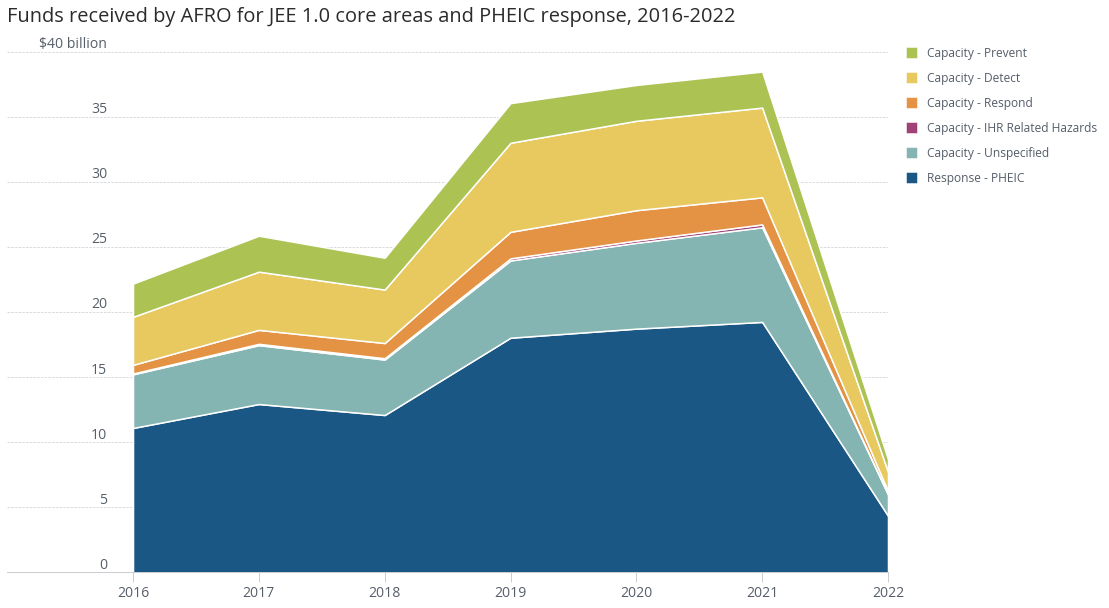

In [460]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,40e9)

# Set title
title = "Funds received by AFRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/afro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### AMRO

In [152]:
# Pivot the DataFrame with species as columns
amro_df = amro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
amro_df.reset_index(inplace=True)

# Calculate total for each row
amro_df['Total'] = amro_df.sum(axis=1)

amro_df['Prevent'] = amro_df['P.1'] + amro_df['P.3'] + amro_df['P.4'] + amro_df['P.5'] + amro_df['P.6'] + amro_df['P.7']
amro_df['Detect'] = amro_df['D.1'] + amro_df['D.2'] + amro_df['D.3'] + amro_df['D.4']
amro_df['Respond'] = amro_df['R.1'] + amro_df['R.2'] + amro_df['R.3'] + amro_df['R.4'] + amro_df['R.5'] 
amro_df['IHR Related Hazards'] = amro_df['RE'] + amro_df['PoE']
# amro_df['Not specified'] = amro_df['Unspecified']


#### Stacked bar chart

In [153]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=amro_df['Date']
# y1=amro_df['Prevent'] 
# y2=amro_df['Detect']
# y3=amro_df['Respond']
# y4=amro_df['IHR Related Hazards']
# y5=amro_df['Not specified']
# y6 = amro_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by AMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/amro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Area chart

In [154]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by AMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/amro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### EMRO

In [155]:
# Pivot the DataFrame with species as columns
emro_df = emro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
emro_df.reset_index(inplace=True)

# Calculate total for each row
emro_df['Total'] = emro_df.sum(axis=1)

emro_df['Prevent'] = emro_df['P.1'] + emro_df['P.3'] + emro_df['P.4'] + emro_df['P.5'] + emro_df['P.6'] + emro_df['P.7']
emro_df['Detect'] = emro_df['D.1'] + emro_df['D.2'] + emro_df['D.3'] + emro_df['D.4']
emro_df['Respond'] = emro_df['R.1'] + emro_df['R.2'] + emro_df['R.3'] + emro_df['R.4'] + emro_df['R.5'] 
emro_df['IHR Related Hazards'] = emro_df['CE'] + emro_df['RE'] + emro_df['PoE']
# emro_df['Not specified'] = emro_df['Unspecified']

#### Stacked bar chart

In [156]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=emro_df['Date']
# y1=emro_df['Prevent'] 
# y2=emro_df['Detect']
# y3=emro_df['Respond']
# y4=emro_df['IHR Related Hazards']
# y5=emro_df['Not specified']
# y6 = emro_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by EMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/emro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Area chart

In [157]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by EMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/emro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### EURO

In [158]:
# Pivot the DataFrame with species as columns
euro_df = euro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
euro_df.reset_index(inplace=True)

# Calculate total for each row
euro_df['Total'] = euro_df.sum(axis=1)


euro_df['Prevent'] = euro_df['P.1'] +  euro_df['P.3'] + euro_df['P.4'] + euro_df['P.5'] + euro_df['P.6'] + euro_df['P.7']
euro_df['Detect'] = euro_df['D.1'] + euro_df['D.2'] + euro_df['D.3'] + euro_df['D.4']
euro_df['Respond'] = euro_df['R.1'] + euro_df['R.2'] + euro_df['R.3'] + euro_df['R.4'] + euro_df['R.5'] 
euro_df['IHR Related Hazards'] = euro_df['CE'] + euro_df['RE'] + euro_df['PoE']
# euro_df['Not specified'] = euro_df['Unspecified']


#### Stacked bar chart

In [159]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=euro_df['Date']
# y1=euro_df['Prevent'] 
# y2=euro_df['Detect']
# y3=euro_df['Respond']
# y4=euro_df['IHR Related Hazards']
# y5=euro_df['Not specified']
# y6 = euro_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by EURO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/euro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Area chart

In [160]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by EURO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/euro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### SEARO

In [161]:
# Pivot the DataFrame with species as columns
searo_df = searo.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
searo_df.reset_index(inplace=True)

# Calculate total for each row
searo_df['Total'] = searo_df.sum(axis=1)

searo_df['Prevent'] = searo_df['P.1'] + searo_df['P.3'] + searo_df['P.4'] + searo_df['P.5'] + searo_df['P.6'] + searo_df['P.7']
searo_df['Detect'] = searo_df['D.1'] + searo_df['D.2'] + searo_df['D.3'] + searo_df['D.4']
searo_df['Respond'] = searo_df['R.1'] + searo_df['R.2'] + searo_df['R.3'] + searo_df['R.4'] + searo_df['R.5'] 
searo_df['IHR Related Hazards'] = searo_df['RE'] + searo_df['PoE']
# searo_df['Not specified'] =  searo_df['Unspecified']

#### Stacked bar chart

In [162]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=searo_df['Date']
# y1=searo_df['Prevent'] 
# y2=searo_df['Detect']
# y3=searo_df['Respond']
# y4=searo_df['IHR Related Hazards']
# y5=searo_df['Not specified']
# y6 = searo_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by SEARO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/searo_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Area chart

In [163]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by SEARO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/searo_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### WPRO

In [164]:
# Pivot the DataFrame with species as columns
wpro_df = wpro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
wpro_df.reset_index(inplace=True)

# Calculate total for each row
wpro_df['Total'] = wpro_df.sum(axis=1)

wpro_df['Prevent'] = wpro_df['P.1'] + wpro_df['P.3'] + wpro_df['P.4'] + wpro_df['P.5'] + wpro_df['P.6'] + wpro_df['P.7']
wpro_df['Detect'] = wpro_df['D.1'] + wpro_df['D.2'] + wpro_df['D.3'] + wpro_df['D.4']
wpro_df['Respond'] = wpro_df['R.1'] + wpro_df['R.2'] + wpro_df['R.3'] + wpro_df['R.4'] + wpro_df['R.5'] 
wpro_df['IHR Related Hazards'] =  wpro_df['RE'] + wpro_df['PoE']
# wpro_df['Not specified'] =  wpro_df['Unspecified']

#### Stacked bar chart

In [165]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=wpro_df['Date']
# y1=wpro_df['Prevent'] 
# y2=wpro_df['Detect']
# y3=wpro_df['Respond']
# y4=wpro_df['IHR Related Hazards']
# y5=wpro_df['Not specified']
# y6 = wpro_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by WPRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/wpro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

#### Area chart

In [166]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,10e9)

# # Set title
# title = "Funds received by WPRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/wpro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### All regions, total funding
- 2016-2022
- Capacity and PHEIC response
- WHO region recipients only

#### Stacked bar chart

In [168]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Define variables
# x=afro_df['Date']
# y1=afro_df['Total'] 
# y2=amro_df['Total']
# y3=emro_df['Total']
# y4=euro_df['Total']
# y5=searo_df['Total']
# y6 = wpro_df['Total']


# # Plot bars
# # The thing that gets plotted last in this list gets plotted on the bottom
# bar_width = 150
# plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='AFRO')
# plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='AMRO')
# plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='EMRO')
# plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='EURO')
# plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='SEARO')
# plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='WPRO')



# # ax.xaxis_date()

# # Define x-axis range
# left = dt.date(2015,1,1)
# right = dt.date(2022,4,1)

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,20e9)

# # Set title
# title = "Funds received by WHO regions for JEE 1.0 core areas, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if y == 20e9 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-70) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.1,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad = 1.5)
# # plt.show()
# # plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/no_unspecified_all_who_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
# #             edgecolor='w', 
# #             orientation='portrait')

In [169]:
# # Format figure
# fig, ax = plt.subplots(figsize=(16,9))
# ax.spines.left.set_visible(False)

# # Format bottom axis
# for axis in ['bottom']:
#     ax.spines[axis].set_color(chart[2])
    
# # Add grid lines    
# plt.grid(axis='y')

# # Combine y-values into a list of lists
# reversed_y_values = [y6, y5, y4, y3, y2, y1]


# x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

# labels = ['AFRO','AMRO','EMRO','EURO','SEARO', 'WPRO']

# # Stackplot using x and y_values
# plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# # Define x-axis range
# left = 2015
# right = 2022

# # Changes x-axis range
# plt.gca().set_xbound(left, right)

# # Changes y-axis range
# plt.gca().set_ybound(0,30e9)

# # Set title
# title = "Funds received by WHO regions for JEE 1.0 core areas and PHEIC response, 2016-2022"
# plt.title(title, fontdict=titlefont, loc='left')

# # Set x-axis label
# plt.xlabel("")

# # Extend x-axis without showing labels
# for label in ax.xaxis.get_ticklabels()[:1]:
#     label.set_visible(False)
    
# for x in ax.xaxis.get_major_ticks()[:1]:
#     x.set_visible(False) 
    
# for x in ax.xaxis.get_minor_ticks()[:3]:
#     x.set_visible(False)
    
# # Format y-axis label
# plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
# for tick in ax.get_yticklabels():
#     tick.set_verticalalignment("bottom")


# tick_values = plt.gca().get_yticks()
# tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

# plt.gca().set_yticklabels(tick_labels)

# plt.gca().yaxis.set_tick_params(pad=-100) 

# # Get the legend and modify the handles
# handles, labels = ax.get_legend_handles_labels()
# handles.reverse()
# leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

# plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/all_who_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

#### Relative proportions

In [170]:
# Creating a new DataFrame by concatenating the columns
new_df = pd.concat([y1, y2, y3, y4, y5, y6], axis=1)

# Adding meaningful column names
new_df.columns = ['Total_AFRO', 'Total_AMRO', 'Total_EMRO', 'Total_EURO', 'Total_SEARO', 'Total_WPRO']

# Calculate total for each row
new_df['Total'] = new_df.sum(axis=1)

In [171]:
new_df['Date'] = pd.to_datetime(['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01','2021-01-01','2022-01-01'])

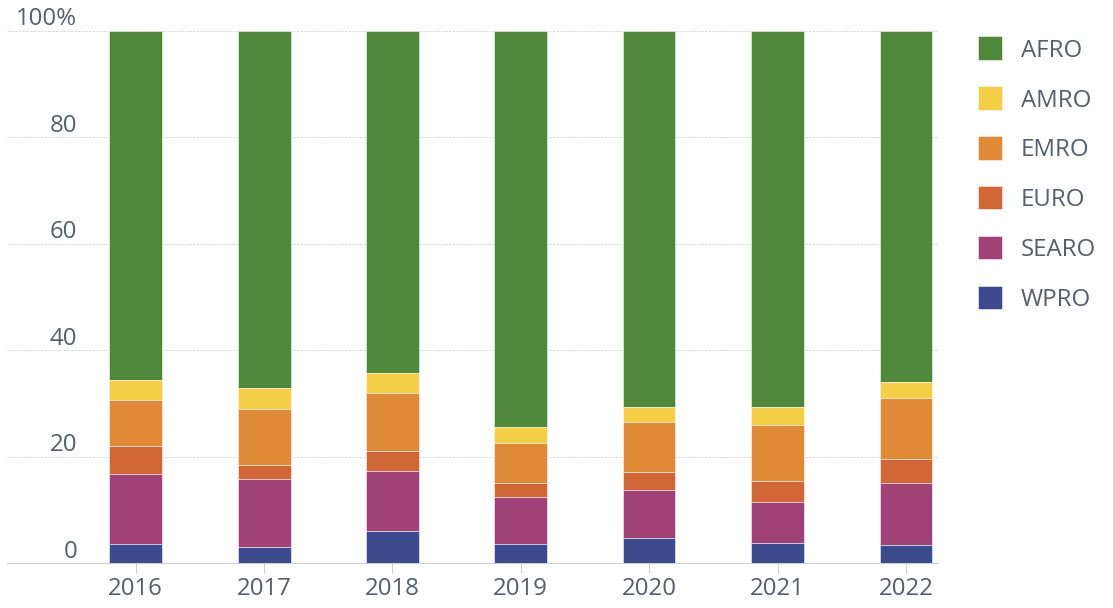

In [186]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=new_df['Date']
y1=(new_df['Total_AFRO']/new_df['Total'])*100 
y2=(new_df['Total_AMRO']/new_df['Total'])*100 
y3=(new_df['Total_EMRO']/new_df['Total'])*100 
y4=(new_df['Total_EURO']/new_df['Total'])*100 
y5=(new_df['Total_SEARO']/new_df['Total'])*100 
y6 = (new_df['Total_WPRO']/new_df['Total'])*100 


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color='#4F883A', label='AFRO')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color='#F5CE47', label='AMRO')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color='#E08A37', label='EMRO')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color='#D16637', label='EURO')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color='#A04275', label='SEARO')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color='#3D4A8D', label='WPRO')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = ""
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if y == 100 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/no_unspecified_all_who_recipient_capacity_and_response_2016-22_bigleg.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

## 3. How many new players are entering the funding landscape?
- Number of unique relationships per year
- Capacity and response
- 2016-2022

### Cleaning

In [53]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Flows by funder, core capacity, recipient, and year/results/Flows by funder, recipient, capacity, and year__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
pre = raw[raw['Year'] >= 2016]
pre = pre[pre['Year'] <= 2019]

post = raw[raw['Year'] >= 2020]
post = post[post['Year'] <= 2022]


# Show data
pre.head()

,Year,Funding type,Category,Core capacity,Funder Name,Funder Category,Funder Subcategory,Recipient Name,Recipient Category,Recipient Subcategory,Total Disbursed to Recipient,Date
26760,2019,capacity,Unspecified,Unspecified,AFEW International,NaN,ngo,Kyrgyzstan,Country,country,394975.52180,2019-01-01
26761,2019,capacity,Unspecified,Unspecified,AFEW International,NaN,ngo,Ukraine,Country,country,285847.34600,2019-01-01
26762,2019,capacity,Respond,Linking Public Health and Security Authorities,AFEW International,NaN,ngo,Georgia,Country,country,104635.41860,2019-01-01
26763,2019,capacity,Prevent,"National Legislation, Policy, and Financing",AFEW International,NaN,ngo,Georgia,Country,country,104635.41860,2019-01-01
26764,2019,capacity,Respond,Linking Public Health and Security Authorities,AFEW International,NaN,ngo,Tajikistan,Country,country,41448.01976,2019-01-01


In [54]:
pre = pre.dropna()

post = post.dropna()

In [55]:
pre = pre.groupby(['Funder Category', 'Recipient Category']).agg({
    'Total Disbursed to Recipient': 'sum',
}).reset_index()

# Rename columns if needed
pre.columns = ['Funder Category', 'Recipient Category', 'Total Disbursed to Recipient']


In [56]:
post = post.groupby(['Funder Category', 'Recipient Category']).agg({
    'Total Disbursed to Recipient': 'sum',
}).reset_index()

# Rename columns if needed
post.columns = ['Funder Category', 'Recipient Category', 'Total Disbursed to Recipient']


In [60]:
new_row = {'Funder Category': 'Country', 'Recipient Category': 'Philanthropy', 'Total Disbursed to Recipient': 0.1}
post = post.append(new_row, ignore_index=True)


In [86]:
pre['Percent'] = round((pre['Total Disbursed to Recipient'] / pre['Total Disbursed to Recipient'].sum(axis=0)) * 100)
post['Percent'] = round((post['Total Disbursed to Recipient'] / post['Total Disbursed to Recipient'].sum(axis=0)) * 100)


In [87]:
pre.sort_values(by="Total Disbursed to Recipient")


,Funder Category,Recipient Category,Total Disbursed to Recipient,Percent
11,Philanthropy,Other,5.500000e+05,0.0
8,Other,Philanthropy,1.000000e+06,0.0
7,Other,International,4.026569e+06,0.0
12,Philanthropy,Philanthropy,4.750000e+06,0.0
10,Philanthropy,International,1.097544e+08,0.0
6,Other,Country,2.345638e+08,0.0
4,International,International,4.915292e+08,0.0
5,International,Other,3.872331e+09,3.0
9,Philanthropy,Country,1.068659e+10,7.0
2,Country,Other,1.349267e+10,9.0


In [85]:
post.sort_values(by="Total Disbursed to Recipient")

,Funder Category,Recipient Category,Total Disbursed to Recipient,Percent
12,Country,Philanthropy,1.000000e-01,0.0
8,Other,Other,2.000000e+06,0.0
11,Philanthropy,Other,2.609445e+07,0.0
10,Philanthropy,International,2.223242e+08,0.0
6,Other,Country,2.354085e+08,0.0
7,Other,International,8.995201e+08,0.0
4,International,International,9.433275e+08,1.0
5,International,Other,3.531386e+09,2.0
9,Philanthropy,Country,5.812534e+09,3.0
2,Country,Other,1.034155e+10,6.0


### Sankey

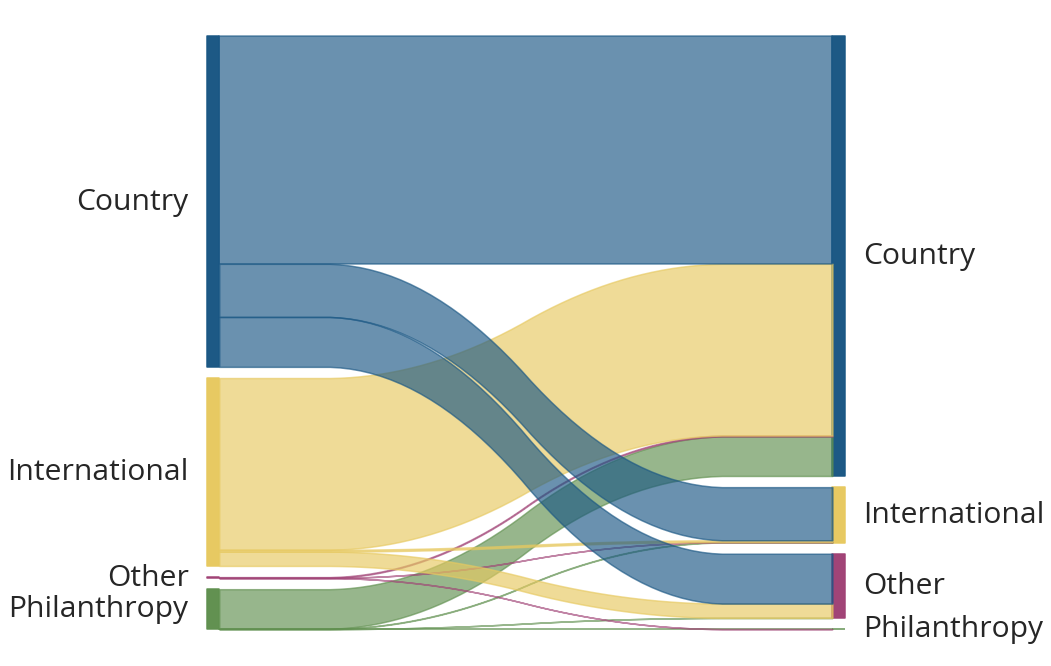

In [72]:
color_map = {
    'Country': colors[0],
    'International': colors[5],
    'Other': colors[8],
    'Philanthropy': colors[3]
}


# Create the Sankey diagram
sankey(
    left=pre["Funder Category"], fontsize=30, leftLabels=["Philanthropy","Other","International","Country"], right=pre["Recipient Category"],rightLabels=["Philanthropy","Other","International","Country"],leftWeight=pre["Total Disbursed to Recipient"], rightWeight=pre["Total Disbursed to Recipient"], colorDict=color_map
)


fig = plt.gcf()

# Set size in inches
fig.set_size_inches(16, 12)

# Set the color of the background to white
fig.set_facecolor("w")



# plt.show()

plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/sankey_precovid_2016-19.png', dpi=1000, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

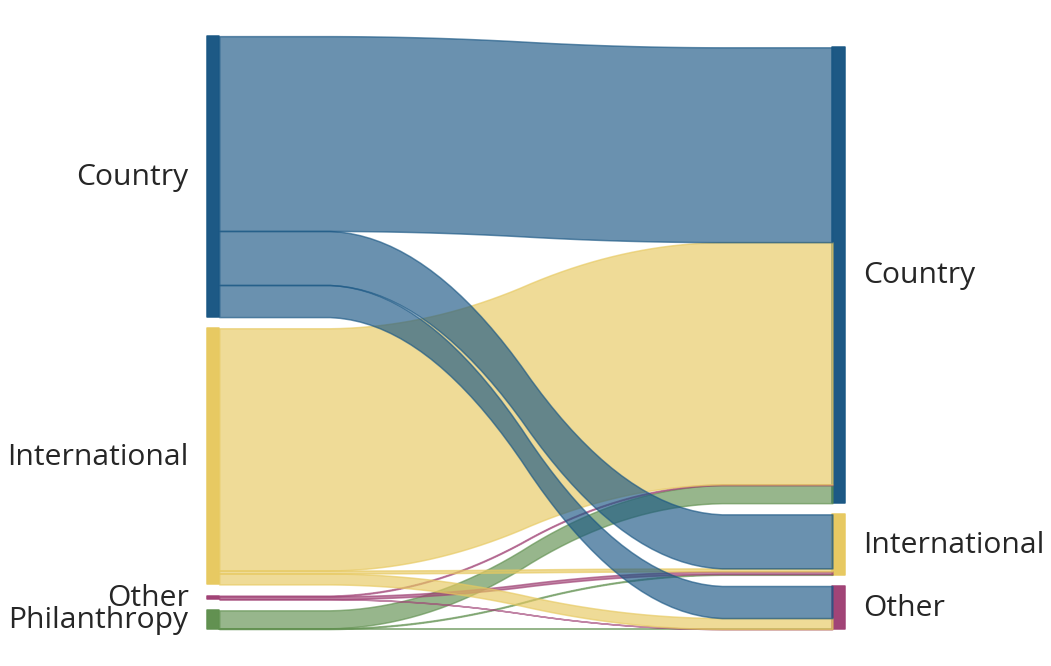

In [73]:
color_map = {
    'Country': colors[0],
    'International': colors[5],
    'Other': colors[8],
    'Philanthropy': colors[3]
}


# Create the Sankey diagram
sankey(
    left=post["Funder Category"], leftLabels=["Philanthropy","Other","International","Country"], right=post["Recipient Category"], 
    rightLabels=["Other","International","Country"],
    leftWeight=post["Total Disbursed to Recipient"], rightWeight=post["Total Disbursed to Recipient"],colorDict=color_map,fontsize=30
)

fig = plt.gcf()

# Set size in inches
fig.set_size_inches(16, 12)

# Set the color of the background to white
fig.set_facecolor("w")

# plt.show

plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/sankey_covid_2020-22.png', dpi=1000, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')


## Bar chart

In [710]:
uq_relationships = df.groupby(['Date', 'Funder Name', 'Recipient Name']).size().reset_index(name='Relationship Count')

uq_relationships["Relationship Count"] = 1

uq_relationships = uq_relationships.groupby('Date').sum('Relationship Count').reset_index()

uq_relationships

,Date,Relationship Count
0,2016-01-01,2636
1,2017-01-01,2912
2,2018-01-01,3070
3,2019-01-01,3102
4,2020-01-01,4379
5,2021-01-01,3949
6,2022-01-01,2179


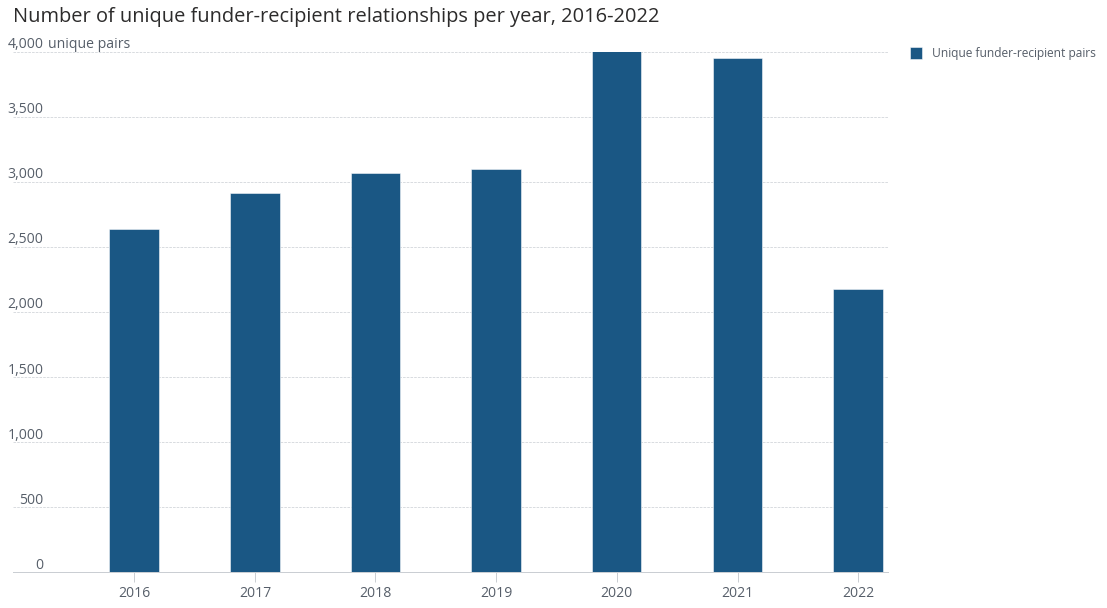

In [711]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=uq_relationships['Date']
y=uq_relationships['Relationship Count']

bar_width=150

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
plt.bar(x, y, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Unique funder-recipient pairs')

# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,4000)

# Set title
title = "Number of unique funder-recipient relationships per year, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("unique pairs", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-30) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/uq_pairings_year_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Bubble plot by number of relationships

In [10]:
bubs = df.groupby(['Date', 'Funder Category','Recipient Category','Funder Name','Recipient Name']).size().reset_index(name='Relationship Count')
bubs["Relationship Count"] = 1

bubs = bubs.groupby(['Funder Category','Recipient Category']).sum('Relationship Count').reset_index()


In [11]:
bubs.head()

,Funder Category,Recipient Category,Relationship Count
0,Country,Country,7459
1,Country,International,332
2,Country,Other,53
3,International,Country,7790
4,International,International,55


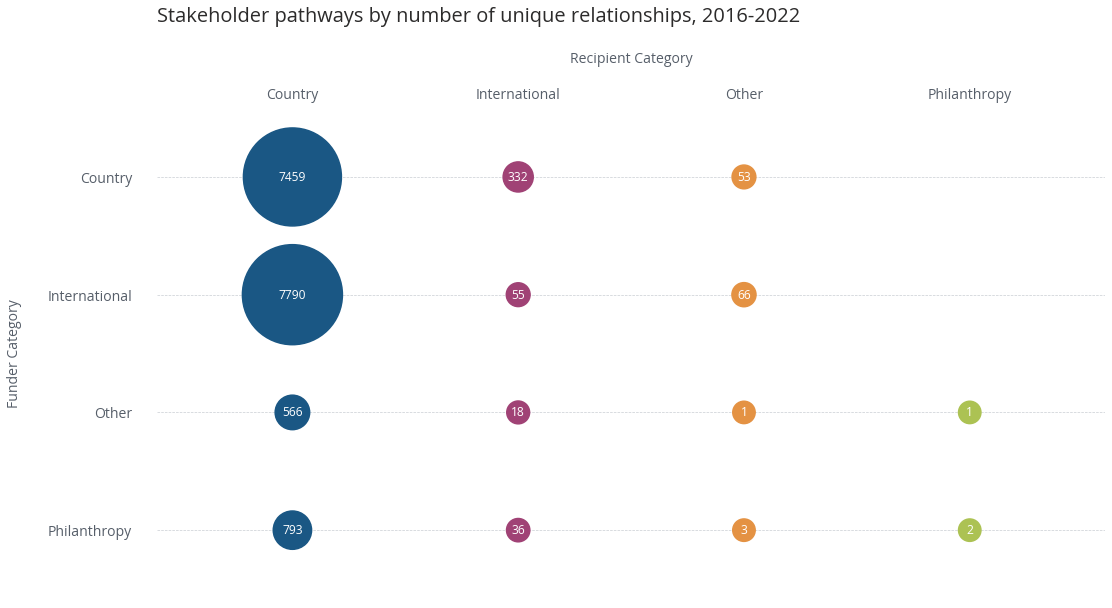

In [12]:
# Define a dictionary of colors for each Recipient Category
category_colors = {
    'Country': colors[0],
    'International': colors[8],
    'Other': colors[6],
    'Philanthropy': colors[4],
}

# Format figure
fig, ax = plt.subplots(figsize=(16, 9))
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
y = bubs['Funder Category']
x = bubs['Recipient Category'] 
s = bubs["Relationship Count"]

# Define the minimum and maximum size values
min_size = 500  # Adjust this value as needed
max_size = 10000

# Scale the size values to be between min_size and max_size
scaled_sizes = np.interp(s, (min(s), max(s)), (min_size, max_size))

# Plot bubbles with scaled sizes
plt.scatter(x, y, scaled_sizes, c=bubs['Recipient Category'].map(category_colors))

# Add text labels to the middle of each circle
for i, txt in enumerate(s):
    plt.annotate(txt, (x.iloc[i], y.iloc[i]), ha='center', va='center', fontsize=12,color='white')


# Set title
title = "Stakeholder pathways by number of unique relationships, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set tick labels and axis labels
ax.set_xlabel('Recipient Category', labelpad=25)
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', length=0, top=True, labeltop=True, bottom=False, labelbottom=False)
plt.margins(x=0.2, y=0.2)

ax.set_ylabel('Funder Category', labelpad=25)
ax.tick_params(axis='y', pad=25)

plt.setp(ax.get_yticklabels(), rotation=0)

# Reverse the y-axis
ax.invert_yaxis()

plt.tight_layout(pad=1.5)

# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/funder_pathway_sizes.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

## 4. What is the value of each funding pathway?
- Funding by category of funder/recipient
- Capacity and response
- 2016-2022

### Bubble plot by value of relationships

In [235]:
dots = df[df["Core capacity"]!="Unspecified"]
dots = dots[dots["Core capacity"]!="General IHR"]
cap = dots[dots["Funding type"]=="capacity"]

prep = df[df["Funding type"]=="response"]


KeyError: 'Core capacity'

In [1110]:
cap = dots.groupby(['Funder Category','Recipient Category','Funder Name','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()
prep = prep.groupby(['Funder Category','Recipient Category','Funder Name','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()

cap = cap.groupby(['Funder Category','Recipient Category']).sum('Total Disbursed to Recipient').reset_index()
prep = prep.groupby(['Funder Category','Recipient Category']).sum('Total Disbursed to Recipient').reset_index()

In [1111]:
# Data for the new row
row = {'Funder Category': "Philanthropy", 'Recipient Category': 'Philanthropy', "Year":48456,"Total Disbursed to Recipient":0}

# Add the new row to the DataFrame
cap = cap.append(row, ignore_index=True)
prep = prep.append(row, ignore_index=True)

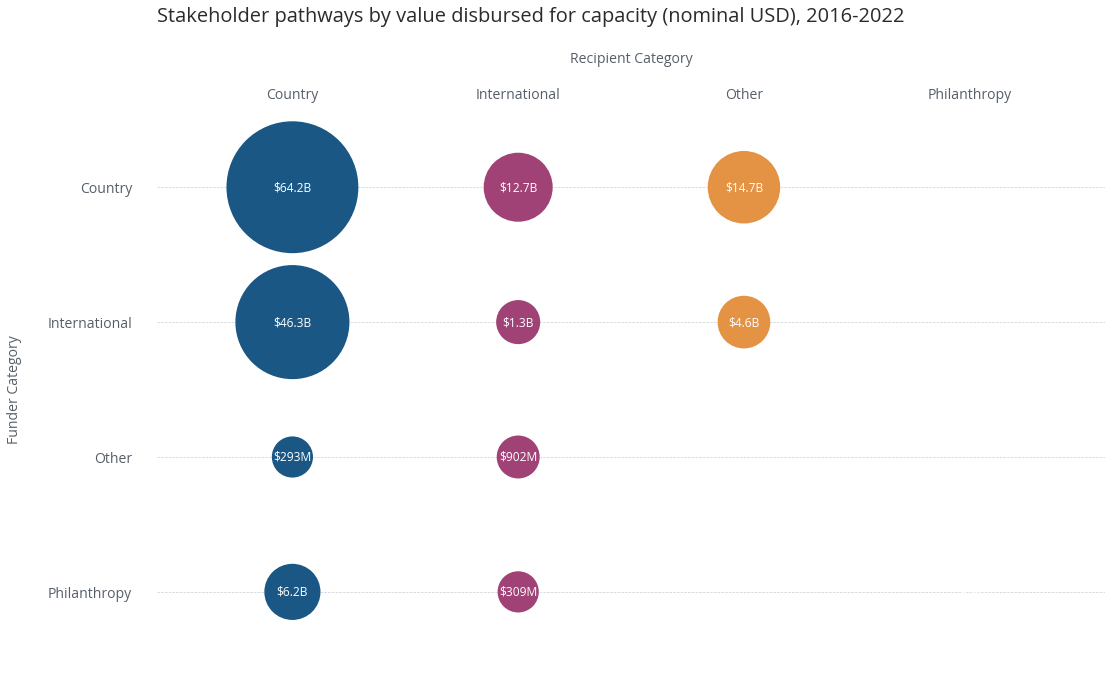

In [1086]:
# Define a dictionary of colors for each Recipient Category
category_colors = {
    'Country': colors[0],
    'International': colors[8],
    'Other': colors[6],
    'Philanthropy': colors[4],
}

# Format figure
fig, ax = plt.subplots(figsize=(16, 10))
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
y = cap['Funder Category']
x = cap["Recipient Category"]
s = cap["Total Disbursed to Recipient"]

# Define the minimum and maximum size values
min_size = 1500
max_size = 17000

# Scale the size values to be between min_size and max_size
scaled_sizes = np.interp(s, (min(s), max(s)), (min_size, max_size))

# Manually change the value at index i to a new_value (this means Phil doesn't show up as 0M)
i = -1  # Replace with the index you want to change
new_value = 0  # Replace with the value you want to assign
scaled_sizes[i] = new_value

# Plot bubbles with scaled sizes
plt.scatter(x, y, scaled_sizes, c=cap['Recipient Category'].map(category_colors))

# Add text labels to the middle of each circle
for i, txt in enumerate(s):
    label_text = '${:,.1f}B'.format(txt / 1e9) if txt>1000000000 else '${:,.0f}M'.format(txt/1e6)
    plt.annotate(label_text, (x.iloc[i], y.iloc[i]), ha='center', va='center', fontsize=12,color='white')


# Set title
title = "Stakeholder pathways by value disbursed for capacity (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set tick labels and axis labels
ax.set_xlabel('Recipient Category', labelpad=25)
ax.xaxis.set_label_position('top')
# Format the x-axis date labels
ax.tick_params(axis='x', length=0, top=True, labeltop=True, bottom=False, labelbottom=False)
plt.margins(x=0.2, y=0.2)

ax.set_ylabel('Funder Category', labelpad=25)
ax.tick_params(axis='y', pad=25)

plt.setp(ax.get_yticklabels(), rotation=0)

# Reverse the y-axis
ax.invert_yaxis()

plt.tight_layout(pad=1.5)

# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/capacity_funder_pathway_values.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

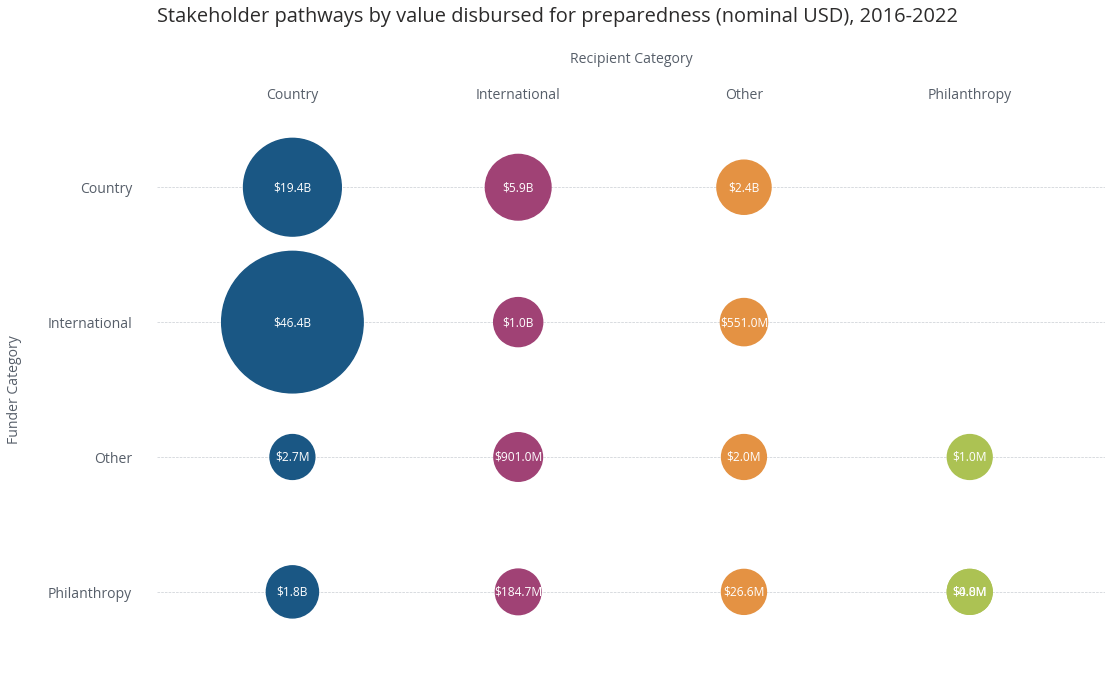

In [1118]:
# Define a dictionary of colors for each Recipient Category
category_colors = {
    'Country': colors[0],
    'International': colors[8],
    'Other': colors[6],
    'Philanthropy': colors[4],
}

# Format figure
fig, ax = plt.subplots(figsize=(16, 10))
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
y = prep['Funder Category']
x = prep["Recipient Category"]
s = prep["Total Disbursed to Recipient"]

# Define the minimum and maximum size values
min_size = 2000
max_size = 20000

# Scale the size values to be between min_size and max_size
scaled_sizes = np.interp(s, (min(s), max(s)), (min_size, max_size))

# # Manually change the value at index i to a new_value (this means Phil doesn't show up as 0M)
# i = -1  # Replace with the index you want to change
# new_value = 0  # Replace with the value you want to assign
# scaled_sizes[i] = new_value

# Plot bubbles with scaled sizes
plt.scatter(x, y, scaled_sizes, c=prep['Recipient Category'].map(category_colors))

# Add text labels to the middle of each circle
for i, txt in enumerate(s):
    label_text = '${:,.1f}B'.format(txt / 1e9) if txt>1000000000 else '${:,.1f}M'.format(txt/1e6)
    plt.annotate(label_text, (x.iloc[i], y.iloc[i]), ha='center', va='center', fontsize=12,color='white')


# Set title
title = "Stakeholder pathways by value disbursed for preparedness (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set tick labels and axis labels
ax.set_xlabel('Recipient Category', labelpad=25)
ax.xaxis.set_label_position('top')
# Format the x-axis date labels
ax.tick_params(axis='x', length=0, top=True, labeltop=True, bottom=False, labelbottom=False)
plt.margins(x=0.2, y=0.2)

ax.set_ylabel('Funder Category', labelpad=25)
ax.tick_params(axis='y', pad=25)

plt.setp(ax.get_yticklabels(), rotation=0)

# Reverse the y-axis
ax.invert_yaxis()

plt.tight_layout(pad=1.5)

# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/response_funder_pathway_values.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Stacked bar chart by value

In [1119]:
# area = df[df["Core capacity"]!="Unspecified"]
# area = area[area["Core capacity"]!="General IHR"]
area = df[df["Funding type"]=="response"]

area = area.groupby(['Year','Funder Category','Recipient Category','Funder Name','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()

area = area.groupby(['Year','Funder Category','Recipient Category']).sum('Total Disbursed to Recipient').reset_index()

area['Pair'] = area["Funder Category"] + "-" + area["Recipient Category"]

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
area['Year'] = pd.to_datetime(area['Year'], format='%Y').dt.year
area['Date'] = pd.to_datetime(area['Year'].astype(str) + '-01-01')

area.head()

,Year,Funder Category,Recipient Category,Total Disbursed to Recipient,Pair,Date
0,2016,Country,Country,6.297866e+08,Country-Country,2016-01-01
1,2016,Country,International,1.026229e+08,Country-International,2016-01-01
2,2016,Country,Other,6.758670e+07,Country-Other,2016-01-01
3,2016,International,Country,6.900569e+08,International-Country,2016-01-01
4,2016,International,International,5.892982e+07,International-International,2016-01-01


In [1122]:
# Pivot the DataFrame with species as columns
pivot = area.pivot_table(index='Date', columns='Pair', values='Total Disbursed to Recipient', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
pivot.reset_index(inplace=True)

pivot['Total'] = pivot.sum(axis=1)


pivot.head()

Pair,Date,Country-Country,Country-International,Country-Other,International-Country,International-International,International-Other,Other-Country,Other-International,Other-Other,Other-Philanthropy,Philanthropy-Country,Philanthropy-International,Philanthropy-Other,Philanthropy-Philanthropy,Total
0,2016-01-01,6.297866e+08,1.026229e+08,6.758670e+07,6.900569e+08,5.892982e+07,1.061368e+07,4.030000e+05,1.497605e+06,0,1000000,3.512832e+08,1.251979e+07,550000,4750000,1.931600e+09
1,2017-01-01,1.964908e+08,7.915514e+06,3.269659e+07,5.679200e+08,1.903292e+06,3.858588e+07,0.000000e+00,2.896446e+04,0,0,3.417296e+08,0.000000e+00,0,0,1.187271e+09
2,2018-01-01,1.532199e+08,5.166351e+07,5.834392e+07,4.795276e+08,3.256380e+07,1.248277e+07,0.000000e+00,0.000000e+00,0,0,2.030681e+08,5.440963e+06,0,0,9.963106e+08
3,2019-01-01,3.774288e+08,1.287539e+08,5.560084e+07,9.378356e+08,5.726639e+07,3.208971e+07,0.000000e+00,0.000000e+00,0,0,1.043192e+08,5.440963e+06,0,0,1.698735e+09
4,2020-01-01,5.499058e+09,3.816429e+09,1.246882e+08,1.683747e+10,5.442737e+08,3.836352e+08,1.816113e+06,2.828564e+08,2000000,0,5.761924e+08,1.087617e+08,12532550,0,2.818971e+10


In [1121]:
# pivot["International-Other"] = 0
# pivot["Other-Philanthropy"]=0
# pivot["Other-Other"] = 0
# pivot["Philanthropy-Country"]=0
# pivot["Philanthropy-Other"]=0
# pivot["Philanthropy-Philanthropy"]=0

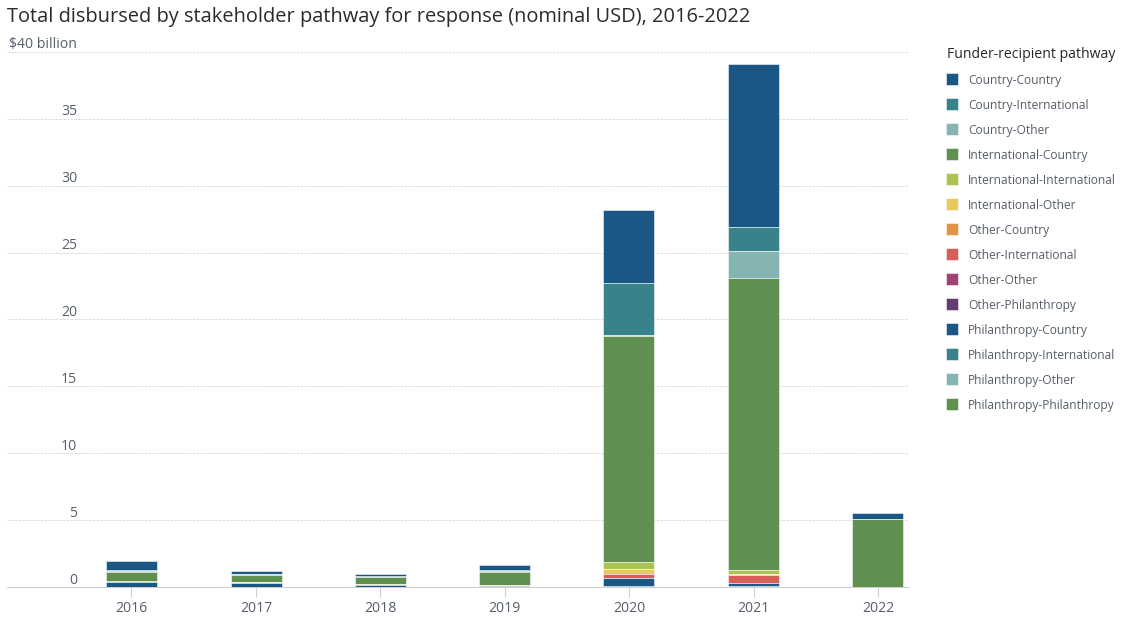

In [1126]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['Date']
y14=pivot['Country-Country']
y13=pivot['Country-International']
y12=pivot['Country-Other']
y11=pivot['International-Country']
y10=pivot['International-International']
y9=pivot['International-Other']
y8=pivot['Other-Country']
y7= pivot['Other-International']
y6 = pivot['Other-Other']
y5 =pivot['Other-Philanthropy']
y4 =pivot['Philanthropy-Country']
y3 =pivot['Philanthropy-International']
y2 =pivot['Philanthropy-Other']
y1 =pivot['Philanthropy-Philanthropy']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y14, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12+y13, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Country-Country')
plt.bar(x, y13, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Country-International')
plt.bar(x, y12, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Country-Other')
plt.bar(x, y11, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='International-Country')
plt.bar(x, y10, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='International-International')
plt.bar(x, y9, bottom=y1+y2+y3+y4+y5+y6+y7+y8, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='International-Other')
plt.bar(x, y8, bottom=y1+y2+y3+y4+y5+y6+y7, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Other-Country')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='Other-International')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Other-Other')
plt.bar(x, y5, bottom=y1+y2+y3+y4, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='Other-Philanthropy')
plt.bar(x, y4, bottom=y1+y2+y3, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Philanthropy-Country')
plt.bar(x, y3, bottom=y1+y2, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Philanthropy-International')
plt.bar(x, y2, bottom=y1, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Philanthropy-Other')
plt.bar(x, y1, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Philanthropy-Philanthropy')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,40e9)

# Set title
title = "Total disbursed by stakeholder pathway for response (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(title="Funder-recipient pathway",title_fontsize=14,handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout()
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/capacity_disbursed_by_pathway_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Area chart

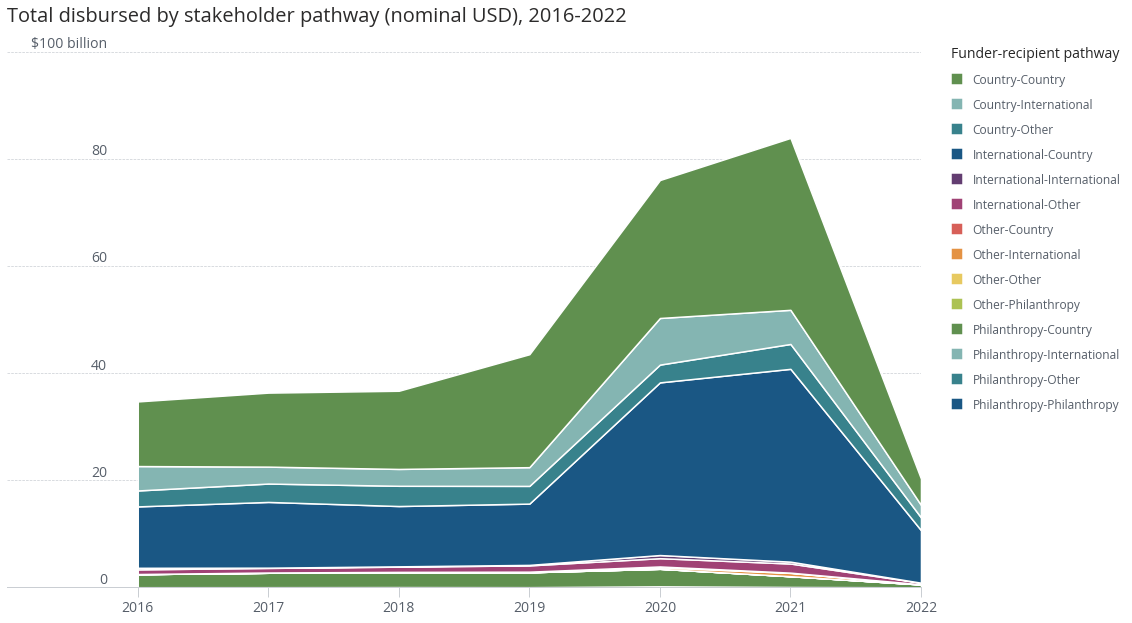

In [93]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
y_values = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14]
reversed_y_values = [y14, y13, y12, y11, y10, y9, y8, y7, y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Country-Country','Country-International','Country-Other','International-Country','International-International','International-Other','Other-Country','Other-International','Other-Other','Other-Philanthropy','Philanthropy-Country','Philanthropy-International','Philanthropy-Other','Philanthropy-Philanthropy']

# Stackplot using x and y_values
plt.stackplot(x, y_values, colors = colors, labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Total disbursed by stakeholder pathway (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(title="Funder-recipient pathway", title_fontsize=14,handles=handles, labels=labels, bbox_to_anchor=(1.23,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_by_pathway_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

### Relative proportions

In [1141]:
# area = df[df["Core capacity"]!="Unspecified"]
# area = area[area["Core capacity"]!="General IHR"]
area = df[df["Funding type"]=="response"]
area.head()
area = area.groupby(['Year','Funder Category','Recipient Category','Funder Name','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()

area = area.groupby(['Year','Funder Category','Recipient Category']).sum('Total Disbursed to Recipient').reset_index()

area['Pair'] = area["Funder Category"] + "-" + area["Recipient Category"]

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
area['Year'] = pd.to_datetime(area['Year'], format='%Y').dt.year
area['Date'] = pd.to_datetime(area['Year'].astype(str) + '-01-01')

area = area[area["Year"]>=2020]

area.head()

,Year,Funder Category,Recipient Category,Total Disbursed to Recipient,Pair,Date
37,2020,Country,Country,5.499058e+09,Country-Country,2020-01-01
38,2020,Country,International,3.816429e+09,Country-International,2020-01-01
39,2020,Country,Other,1.246882e+08,Country-Other,2020-01-01
40,2020,International,Country,1.683747e+10,International-Country,2020-01-01
41,2020,International,International,5.442737e+08,International-International,2020-01-01


In [1142]:
# Pivot the DataFrame with species as columns
pivot = area.pivot_table(index='Date', columns='Pair', values='Total Disbursed to Recipient', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
pivot.reset_index(inplace=True)

pivot['Total'] = pivot.sum(axis=1)

pivot.head()

Pair,Date,Country-Country,Country-International,Country-Other,International-Country,International-International,International-Other,Other-Country,Other-International,Other-Other,Philanthropy-Country,Philanthropy-International,Philanthropy-Other,Total
0,2020-01-01,5.499058e+09,3.816429e+09,1.246882e+08,1.683747e+10,5.442737e+08,3.836352e+08,1.816113e+06,282856380,2000000,5.761924e+08,108761652,12532550,2.818971e+10
1,2021-01-01,1.214575e+10,1.803855e+09,2.006174e+09,2.183908e+10,3.158313e+08,6.062566e+07,4.609902e+05,616663688,0,2.274618e+08,52547526,13561900,3.908201e+10
2,2022-01-01,4.349644e+08,1.304808e+06,1.803185e+07,5.078405e+09,0.000000e+00,1.295089e+07,0.000000e+00,0,0,1.422450e+07,0,0,5.559881e+09


In [1147]:
# pivot["International-Other"] = 0
pivot["Other-Philanthropy"]=0
# pivot["Other-Other"] = 0
# pivot["Philanthropy-Country"]=0
# pivot["Philanthropy-Other"]=0
pivot["Philanthropy-Philanthropy"]=0

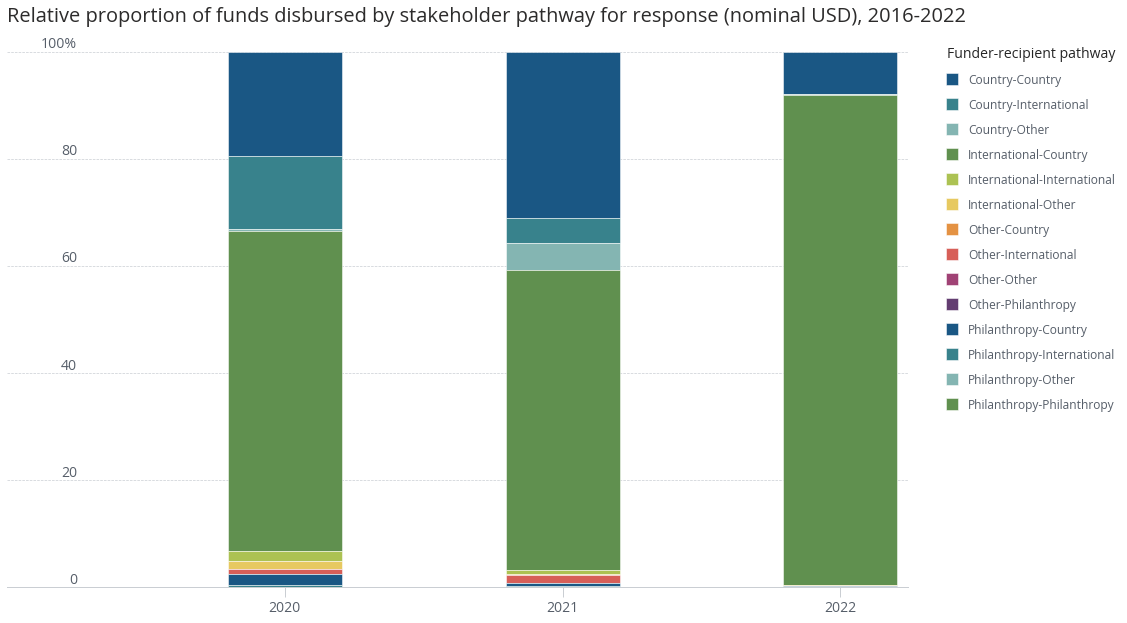

In [1151]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['Date']
y14=(pivot['Country-Country']/pivot['Total'])*100
y13=(pivot['Country-International']/pivot['Total'])*100
y12=(pivot['Country-Other']/pivot['Total'])*100
y11=(pivot['International-Country']/pivot['Total'])*100
y10=(pivot['International-International']/pivot['Total'])*100
y9=(pivot['International-Other']/pivot['Total'])*100
y8=(pivot['Other-Country']/pivot['Total'])*100
y7= (pivot['Other-International']/pivot['Total'])*100
y6= (pivot['Other-Other']/pivot['Total'])*100
y5= (pivot['Other-Philanthropy']/pivot['Total'])*100
y4= (pivot['Philanthropy-Country']/pivot['Total'])*100
y3= (pivot['Philanthropy-International']/pivot['Total'])*100
y2= (pivot['Philanthropy-Other']/pivot['Total'])*100
y1= (pivot['Philanthropy-Philanthropy']/pivot['Total'])*100


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y14, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12+y13, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Country-Country')
plt.bar(x, y13, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Country-International')
plt.bar(x, y12, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Country-Other')
plt.bar(x, y11, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='International-Country')
plt.bar(x, y10, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='International-International')
plt.bar(x, y9, bottom=y1+y2+y3+y4+y5+y6+y7+y8, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='International-Other')
plt.bar(x, y8, bottom=y1+y2+y3+y4+y5+y6+y7, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Other-Country')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='Other-International')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Other-Other')
plt.bar(x, y5, bottom=y1+y2+y3+y4, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='Other-Philanthropy')
plt.bar(x, y4, bottom=y1+y2+y3, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Philanthropy-Country')
plt.bar(x, y3, bottom=y1+y2, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Philanthropy-International')
plt.bar(x, y2, bottom=y1, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Philanthropy-Other')
plt.bar(x, y1, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Philanthropy-Philanthropy')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2019,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Relative proportion of funds disbursed by stakeholder pathway for response (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")
plt.xticks(ticks=x, labels=["2020","2021","2022"],rotation=0, ha="center")

    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(title="Funder-recipient pathway",title_fontsize=14,handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout()
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/covid_disbursed_by_pathway_relative_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

## 5. How did funding fluctuate among the top 25 recipients? 
- Funding received for response and capacity
- 2016-2022

### Cleaning

In [132]:
# Get the top 10 recipients overall
top10 = df.groupby(['Recipient Name']).sum("Total Disbursed to Recipient").reset_index()
top10 = top10.sort_values(by="Total Disbursed to Recipient",ascending=False)
top10 = top10.head(11)
top10 = top10["Recipient Name"].unique().tolist()

# Filter df by those top 10 recipients, excluding not reported
top10_df = df[df["Recipient Name"].isin(top10)]
top10_df = top10_df.groupby(['Date','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()
top10_df = top10_df[top10_df["Recipient Name"] != "Not reported"]

In [133]:
# Create the "other" funded entities
other = df[~df["Recipient Name"].isin(top10)]
other = other.groupby(['Date']).sum("Total Disbursed to Recipient").reset_index()
other["Recipient Name"] = "Other"

In [197]:
# Pivot the DataFrame
pivot = top10_df.pivot_table(index='Date', columns='Recipient Name', values='Total Disbursed to Recipient', aggfunc='sum', fill_value=0)
other_piv = other.pivot_table(index='Date', columns='Recipient Name', values='Total Disbursed to Recipient', aggfunc='sum', fill_value=0)

# Flatten the DataFrame
pivot.reset_index(inplace=True)
other_piv.reset_index(inplace=True)


Recipient Name,Date,Other
0,2016-01-01,1.700259e+10
1,2017-01-01,1.764080e+10
2,2018-01-01,1.803224e+10
3,2019-01-01,2.190002e+10
4,2020-01-01,4.864623e+10


### Stacked bar chart

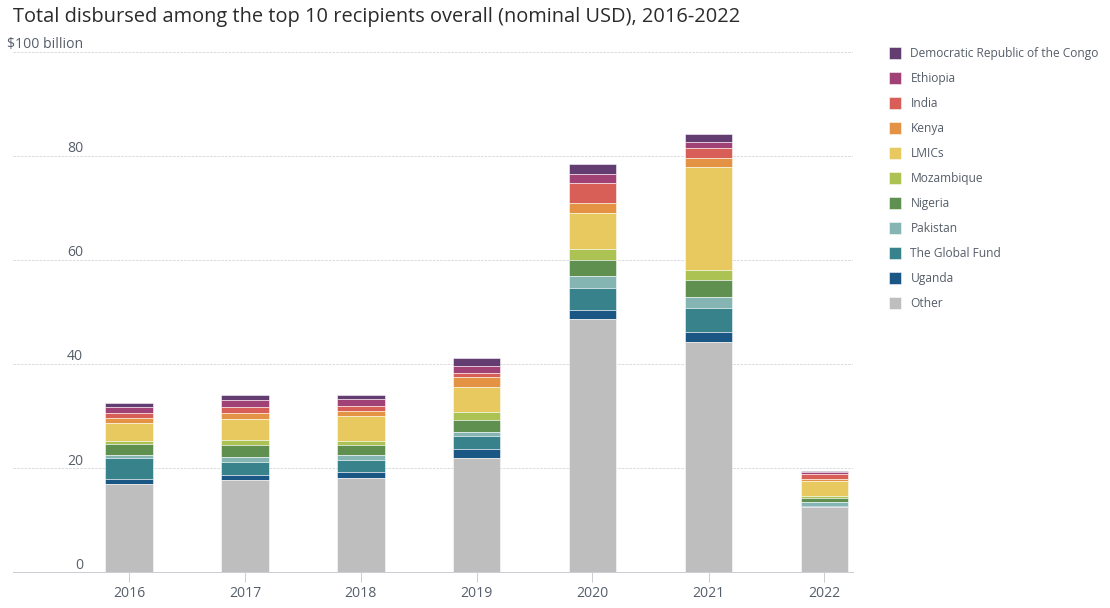

In [208]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x= pivot['Date']
y11= pivot['Democratic Republic of the Congo']
y10= pivot['Ethiopia']
y9= pivot['India']
y8= pivot['Kenya']
y7= pivot['Low and middle-income countries (LMIC)']
y6= pivot['Mozambique']
y5= pivot['Nigeria']
y4= pivot['Pakistan']
y3= pivot['The Global Fund to Fight AIDS, Tuberculosis and Malaria']
y2= pivot['Uganda']
y1= other_piv['Other']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y11, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='Democratic Republic of the Congo')
plt.bar(x, y10, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Ethiopia')
plt.bar(x, y9, bottom=y1+y2+y3+y4+y5+y6+y7+y8, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='India')
plt.bar(x, y8, bottom=y1+y2+y3+y4+y5+y6+y7, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Kenya')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='LMICs')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Mozambique')
plt.bar(x, y5, bottom=y1+y2+y3+y4, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Nigeria')
plt.bar(x, y4, bottom=y1+y2+y3, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Pakistan')
plt.bar(x, y3, bottom=y1+y2, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='The Global Fund')
plt.bar(x, y2, bottom=y1, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Uganda')
plt.bar(x, y1, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[10], label='Other')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Total disbursed among the top 10 recipients overall (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout(pad=1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_to_top10_recipients_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Area chart

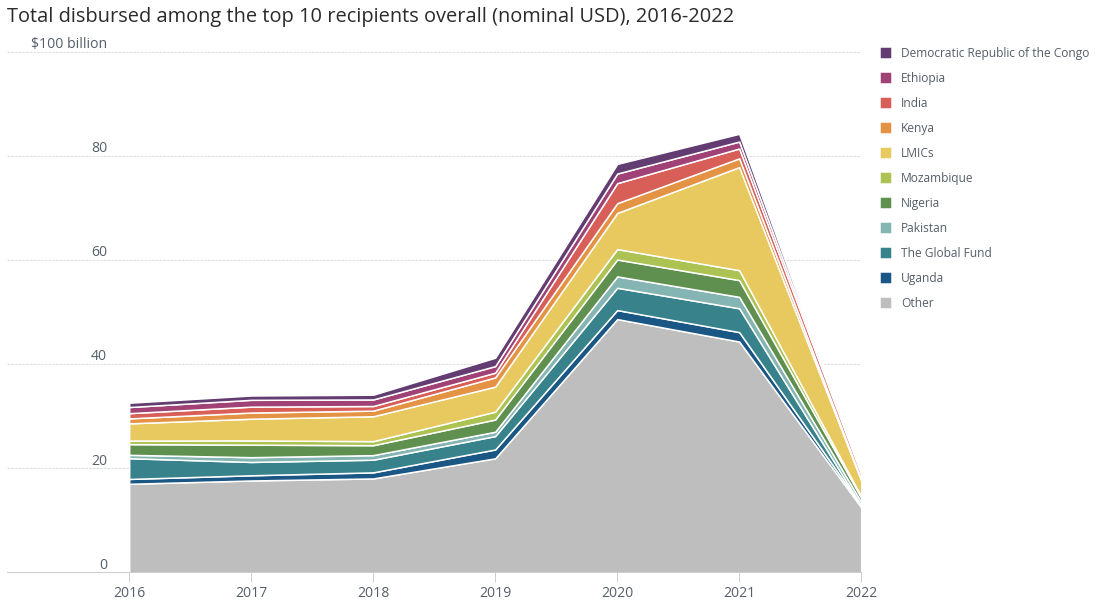

In [222]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
y_values = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11]
reversed_y_values = [y11, y10, y9, y8, y7, y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Democratic Republic of the Congo', 'Ethiopia', 'India', 'Kenya', 'LMICs', 'Mozambique', 'Nigeria', 'Pakistan', 'The Global Fund', 'Uganda', 'Other']
reverse_labels = ['Other', 'Uganda', 'The Global Fund', 'Pakistan', 'Nigeria', 'Mozambique', 'LMICs', 'Kenya', 'India', 'Ethiopia', 'Democratic Republic of the Congo']

#Stackplot using x and y_values
plt.stackplot(x, y_values, colors = ['#BEBEBE','#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71'], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Total disbursed among the top 10 recipients overall (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.28,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_to_top10_recipients_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

## 6. Which capacities are funded together?
- Funding received for capacity
- 2016-2019 and 2020-2022

### PCA Encoding and Cleaning

In [772]:
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Flows by funder, core capacity, recipient, and year/results/Flows with project IDs.csv')
raw.head()

,Year,Project ID,Funding type,Core capacity,Funder Name,Recipient Name,Total Disbursed to Recipient
0,2022.0,4421578,response,Unspecified,AICS - Agenzia Italiana per la Cooperazione al...,Jordan,4.052879e+06
1,2022.0,4396944,capacity,Preparedness,AICS - Agenzia Italiana per la Cooperazione al...,Middle East,3.956632e+06
2,2022.0,4396936,capacity,National Laboratory System,AICS - Agenzia Italiana per la Cooperazione al...,Burkina Faso,1.703291e+06
3,2022.0,4396858,capacity,Unspecified,AICS - Agenzia Italiana per la Cooperazione al...,Jordan,1.154666e+06
4,2022.0,4396753,capacity,Unspecified,AICS - Agenzia Italiana per la Cooperazione al...,Palestine,1.154666e+06


In [591]:
flows = raw[raw["Funding type"] == "capacity"]
flows = flows[flows["Core capacity"] != "Unspecified"]
flows = flows[flows["Total Disbursed to Recipient"] >  100]
flows = flows.groupby(['Project ID','Total Disbursed to Recipient'])['Core capacity'].unique().reset_index()

In [592]:
flows = flows.sort_values(by="Total Disbursed to Recipient",ascending=False)

In [593]:
# Create dummy variables for each core capacity
core_capacity_dummies = flows['Core capacity'].str.join('|').str.get_dummies()

# Concatenate the dummy variables with the original DataFrame
df_encoded = pd.concat([flows, core_capacity_dummies], axis=1)

# Drop the original 'Core capacity' column
df_encoded = df_encoded.drop('Core capacity', axis=1)

In [594]:
from sklearn.decomposition import PCA

# Extract the one-hot encoded core capacities columns
core_capacity_columns = df_encoded.columns[2:]

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(df_encoded[core_capacity_columns])

# Add PCA results to the DataFrame
df_encoded['PCA_1'] = pca_result[:, 0]
df_encoded['PCA_2'] = pca_result[:, 1]

In [595]:
df_encoded = df_encoded.sort_values(by="Total Disbursed to Recipient",ascending=True)

### PCA Scatter

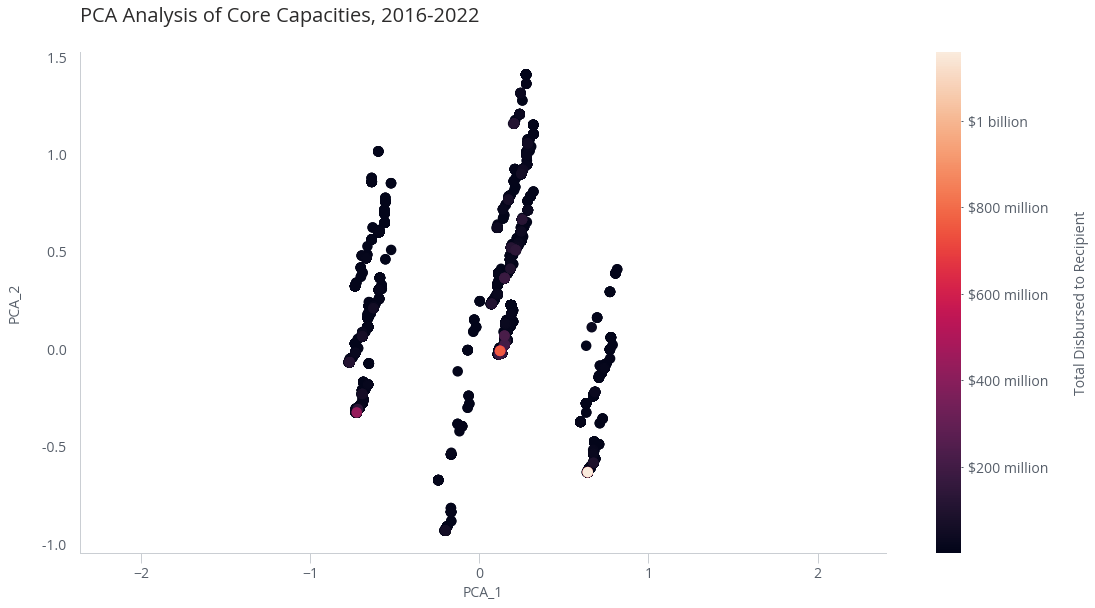

In [577]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(True)

# Format bottom axis
for axis in ['bottom','left']:
    ax.spines[axis].set_color(chart[2])
    

plt.scatter(df_encoded['PCA_1'], df_encoded['PCA_2'], c=df_encoded['Total Disbursed to Recipient'],alpha=1)
    
# Set title
title = "PCA Analysis of Core Capacities, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

plt.xlabel('PCA_1')

  
# Format y-axis label
plt.ylabel("PCA_2", color=chart[1], labelpad=20)
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:.1f} '.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=10) 

# Customize color bar
cbar = plt.colorbar(drawedges=False)
cbar.set_label('Total Disbursed to Recipient', labelpad=25)
cbar.outline.set_visible(False)

# Set custom tick locations and labels
cbar_values = [0, 0.2e9, 0.4e9, 0.6e9, 0.8e9, 1e9]  # Custom tick locations
cbar_labels = ['${:.0f} million'.format(y/1e6) if y != 1e9 else '$1 billion' for y in cbar_values]  # Custom tick labels

cbar.set_ticks(cbar_values)
cbar.set_ticklabels(cbar_labels)

# Customize color bar appearance
cbar.ax.yaxis.set_tick_params(direction='out', length=2, width=1, pad=5, colors=chart[1], labelsize=14)

plt.tight_layout(pad=1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/pca_analysis_core_capacities_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Heat map

In [596]:
# Select the relevant columns (core capacities)
core_capacity_columns = df_encoded.columns[2:-2]  # Exclude the first and last two columns

# Calculate the co-occurrence matrix
cooccurrence_matrix = df_encoded[core_capacity_columns].T.dot(df_encoded[core_capacity_columns])

# Flatten the co-occurrence matrix into a DataFrame
cooccurrence_df = cooccurrence_matrix.unstack().reset_index()
cooccurrence_df.columns = ['Capacity_1', 'Capacity_2', 'Cooccurrence_Count']

# Get the top 5 pairs with the most frequent co-occurrence
top_cooccurrence_pairs = cooccurrence_df.sort_values(by='Cooccurrence_Count', ascending=False)

top_cooccurrence_pairs = top_cooccurrence_pairs[top_cooccurrence_pairs["Capacity_1"] != top_cooccurrence_pairs["Capacity_2"]]

# Drop every other row starting from the second row (index 1)
pairs = top_cooccurrence_pairs.drop(top_cooccurrence_pairs.index[1::2])

# Reset the index if needed
pairs.reset_index(drop=True, inplace=True)

pairs.head(20)

,Capacity_1,Capacity_2,Cooccurrence_Count
0,National Laboratory System,Real Time Surveillance,1620
1,Workforce Development,Reporting,1223
2,Real Time Surveillance,Antimicrobial Resistance (AMR),990
3,Reporting,Real Time Surveillance,988
4,National Laboratory System,Workforce Development,913
5,Real Time Surveillance,Workforce Development,720
6,Antimicrobial Resistance (AMR),National Laboratory System,689
7,Zoonotic Disease,Real Time Surveillance,607
8,Workforce Development,Zoonotic Disease,487
9,National Laboratory System,Reporting,469


In [599]:
columns = ['National Legislation, Policy, and Financing','IHR Coordination, Communicaton and Advocacy',
           'Antimicrobial Resistance (AMR)','Zoonotic Disease','Food Safety','Biosafety and Biosecurity',
           'Immunization','National Laboratory System','Real Time Surveillance','Reporting','Workforce Development',
           'Preparedness','Linking Public Health and Security Authorities',
           'Medical Countermeasures and Personnel Deployment','Risk Communication','Point of Entry (PoE)',
           'Chemical Events','Radiation Emergencies']
     

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = pairs.pivot('Capacity_1', 'Capacity_2', 'Cooccurrence_Count').fillna(0)

heatmap_data = heatmap_data[columns]

# Reorder the rows to match the specified column order
heatmap_data = heatmap_data.reindex(columns, axis=0)


In [600]:
heatmap_data.head()

Capacity_2,"National Legislation, Policy, and Financing","IHR Coordination, Communicaton and Advocacy",Antimicrobial Resistance (AMR),Zoonotic Disease,Food Safety,Biosafety and Biosecurity,Immunization,National Laboratory System,Real Time Surveillance,Reporting,Workforce Development,Preparedness,Linking Public Health and Security Authorities,Medical Countermeasures and Personnel Deployment,Risk Communication,Point of Entry (PoE),Chemical Events,Radiation Emergencies
Capacity_1,,,,,,,,,,,,,,,,,,
"National Legislation, Policy, and Financing",0.0,0.0,0.0,0.0,0.0,0.0,163.0,0.0,0.0,197.0,367.0,0.0,0.0,184.0,0.0,19.0,0.0,1.0
"IHR Coordination, Communicaton and Advocacy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antimicrobial Resistance (AMR),76.0,0.0,0.0,418.0,29.0,7.0,64.0,689.0,0.0,139.0,120.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
Zoonotic Disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,607.0,0.0,0.0,0.0,7.0,20.0,0.0,0.0,0.0,0.0
Food Safety,22.0,0.0,0.0,416.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,153.0


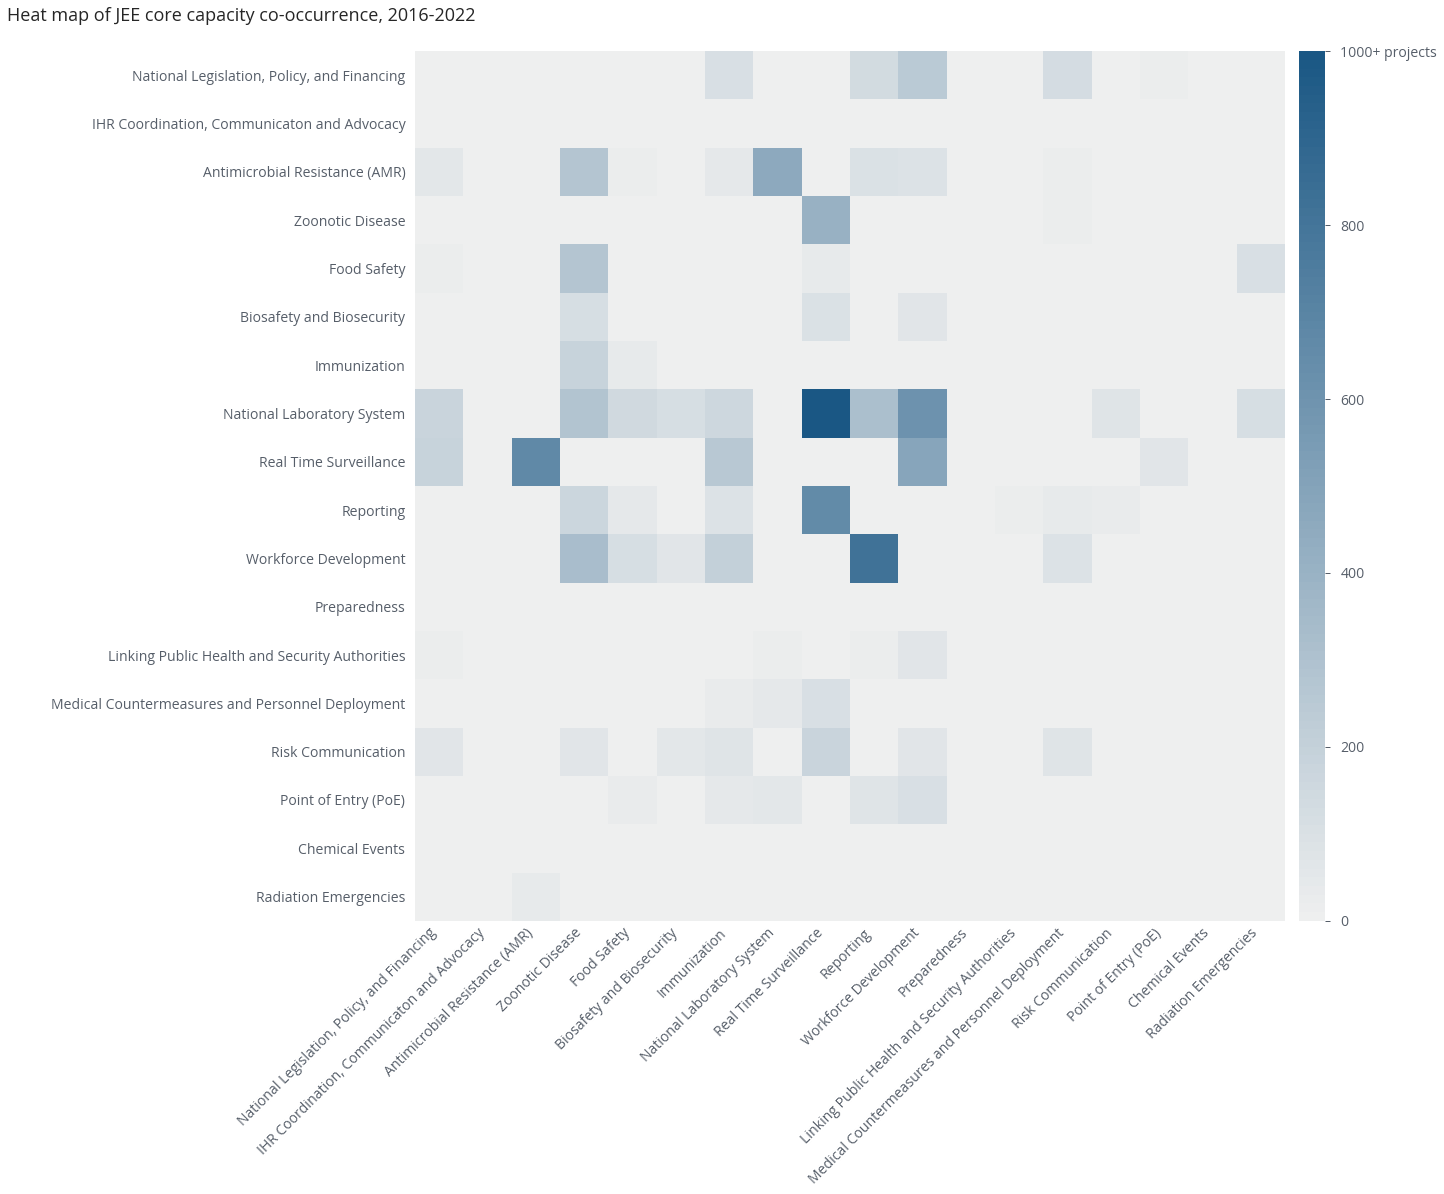

In [648]:
fig, ax = plt.subplots(figsize=(20,20))

im = ax.imshow(heatmap_data, cmap=cm, vmin=vmin, vmax=vmax)

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize())
sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False,pad=20)
cbar.ax.yaxis.set_ticklabels(['0','200','400','600','800','1000+ projects'])
cbar.ax.yaxis.set_tick_params(direction='out',length=5,width=1,pad=10,colors=chart[1],labelsize=14)
cbar.outline.set_visible(False)

# Spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set tick labels and axis labels
ax.set_xticks(range(len(columns)))
ax.set_xticklabels(columns,ha="right")
ax.tick_params(axis='x',pad=5,length=0,labelsize=14,width=30,rotation=45)
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_yticks(range(len(columns)))
ax.set_yticklabels(columns)
ax.tick_params(axis='y',pad=10,width=30,labelsize=14)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)



# Set title and show the plot
ax.set_title("Heat map of JEE core capacity co-occurrence, 2016-2022",fontsize=18,x=-.2)
plt.tight_layout(pad=1.5)
# plt.show()

# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/heatmap_core_capacities_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

## 7. How was funding allocated during PHEICs?
- Funding disbursed and received for response during events (PHEICS)
- All years

#### Cleaning

In [216]:
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Flows by PHEIC/results/Flows by PHEIC year__latest.csv')
raw.drop_duplicates(subset=["Total Disbursed to Recipient", "Recipient Name","PHEIC Name","Year"], keep="first", inplace=True)
raw = raw[raw["Year"]!=2023]

#### Bar chart

In [217]:
df = raw.groupby(['PHEIC Name']).sum("Total Disbursed to Recipient").reset_index()
df["Total Disbursed to Recipient"].sum()

76270492987.22702

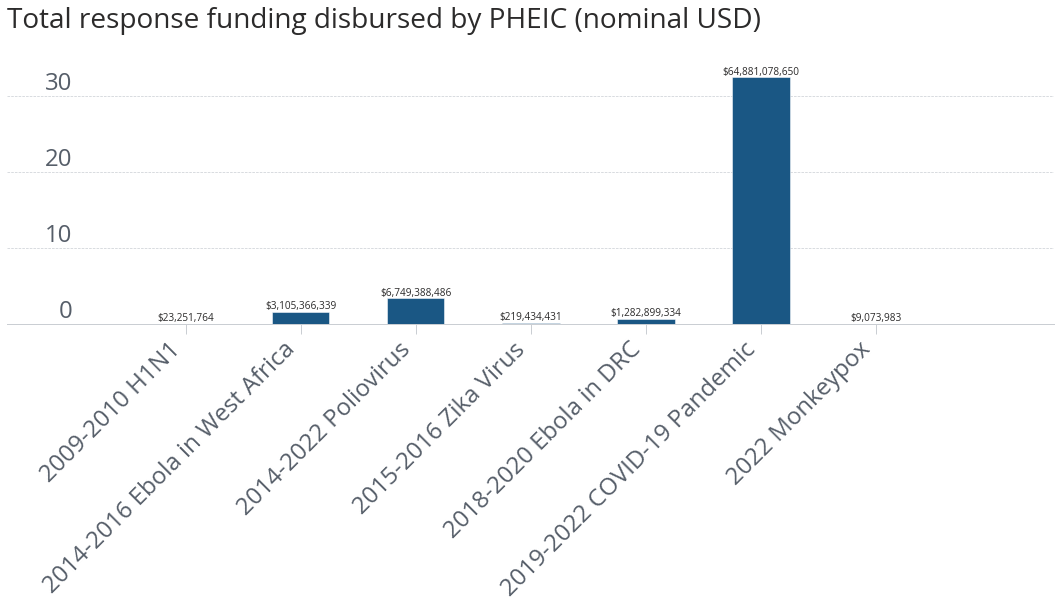

In [218]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=df['PHEIC Name']
y=df['Total Disbursed to Recipient']

bar_width=0.5

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bars = plt.bar(x, y, linewidth=0.5, width=bar_width, align="center", color=colors[0])

# Annotate y-values on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             '${:,.0f}'.format(bar.get_height()),
             ha='center', va='bottom', fontsize=10, color=chart[0])

# Changes y-axis range
plt.gca().set_ybound(0,70000000000)

# Set title
title = "Total response funding disbursed by PHEIC (nominal USD)"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y/1e9) if i ==7 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-65) 

plt.tight_layout(pad = 1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_by_pheic.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

#### COVID Specific

In [219]:
covid = raw[raw["PHEIC Name"]=="2019-2022 COVID-19 Pandemic"]
covid = covid[covid["Year"]>=2020]


In [220]:
covid = covid.groupby(['Year']).sum("Total Disbursed to Recipient").reset_index()
covid['Year'] = pd.to_datetime(covid['Year'], format='%Y').dt.year
covid['Date'] = pd.to_datetime(covid['Year'].astype(str) + '-01-01')

In [221]:
covid

,Year,Total Disbursed to Recipient,Date
0,2020,2.415119e+10,2020-01-01
1,2021,3.537356e+10,2021-01-01
2,2022,5.334448e+09,2022-01-01


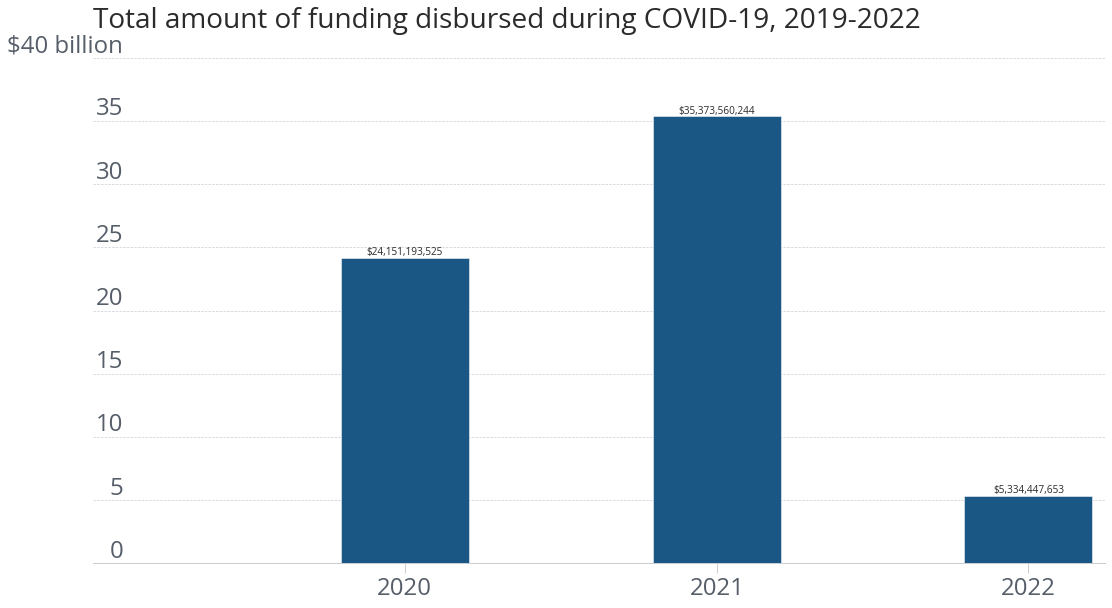

In [222]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x = covid['Date']
y = covid['Total Disbursed to Recipient']

bar_width = 150

# Plot bars
bars = plt.bar(x, y, linewidth=0.5, width=bar_width, align="center", color=colors[0])

# Annotate y-values on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             '${:,.0f}'.format(bar.get_height()),
             ha='center', va='bottom', fontsize=10, color=chart[0])

# Define x-axis range
left = dt.date(2019, 1, 1)
right = dt.date(2022, 4, 1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0, 40e9)

# Set title
title = "Total amount of funding disbursed during COVID-19, 2019-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Set major locator for x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))

# Format the x-axis date labels
plt.xticks(ticks=x, labels=["2020","2021","2022"],rotation=0, ha="center")


# Format y-axis label
plt.ylabel("", rotation=0, loc='top', labelpad=-120, color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")

# Format y-axis tick labels
tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y/1e9) if y == 40e9 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]
plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-30) 

plt.tight_layout(pad=1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_covid.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Funding disbursed

#### Transform

In [223]:
region = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Funders and recipients of PHEICs/results/Funders and recipients of PHEICs year__latest.csv')
region["Funder WHO"] = region["Funder WHO"].fillna("Other")
region["Recipient WHO"] = region["Recipient WHO"].fillna("Other")
region['Year'] = pd.to_datetime(region['Year'], format='%Y').dt.year
region['Date'] = pd.to_datetime(region['Year'].astype(str) + '-01-01')
region.drop_duplicates(subset=["Total Disbursed to Recipient", "Recipient Name","PHEIC Name","Year"], keep="first", inplace=True)

region.head()

,Funder Name,Funder WHO,Recipient Name,Recipient WHO,PHEIC Name,Year,Total Disbursed to Recipient,Date
0,Global Alliance for Vaccines and Immunisation ...,Other,Low and middle-income countries (LMIC),Other,2019-2022 COVID-19 Pandemic,2021,6.380965e+09,2021-01-01
1,United States of America,amro,Low and middle-income countries (LMIC),Other,2019-2022 COVID-19 Pandemic,2021,4.000009e+09,2021-01-01
2,United States Agency for International Develop...,Other,Low and middle-income countries (LMIC),Other,2019-2022 COVID-19 Pandemic,2021,4.000000e+09,2021-01-01
3,Asian Development Bank,Other,Indonesia,searo,2019-2022 COVID-19 Pandemic,2020,1.540552e+09,2020-01-01
4,Asian Development Bank,Other,India,searo,2019-2022 COVID-19 Pandemic,2020,1.500000e+09,2020-01-01


In [224]:
pivot = region.pivot_table(index="PHEIC Name", columns='Funder WHO', values='Total Disbursed to Recipient', aggfunc='sum', fill_value=0).reset_index()
pivot['Total'] = pivot.sum(axis=1,numeric_only=True)
pivot.head()

Funder WHO,PHEIC Name,Other,afro,amro,emro,euro,searo,wpro,Total
0,2009-2010 H1N1,0.000000e+00,0.000000e+00,1.889878e+06,0,2.835926e+06,0,1.852596e+07,2.325176e+07
1,2014-2016 Ebola in West Africa,1.404068e+09,2.132987e+06,4.301322e+08,5000000,6.997630e+08,20662905,1.897097e+08,2.751469e+09
2,2014-2022 Poliovirus,5.653986e+09,0.000000e+00,2.937907e+08,0,7.218113e+08,0,9.614860e+07,6.765737e+09
3,2015-2016 Zika Virus,1.894672e+08,0.000000e+00,1.420832e+07,0,6.830220e+06,0,8.771610e+06,2.192774e+08
4,2018-2020 Ebola in DRC,8.859679e+08,0.000000e+00,2.326336e+08,0,1.829402e+08,0,5.800000e+06,1.307342e+09


#### Stacked bar chart

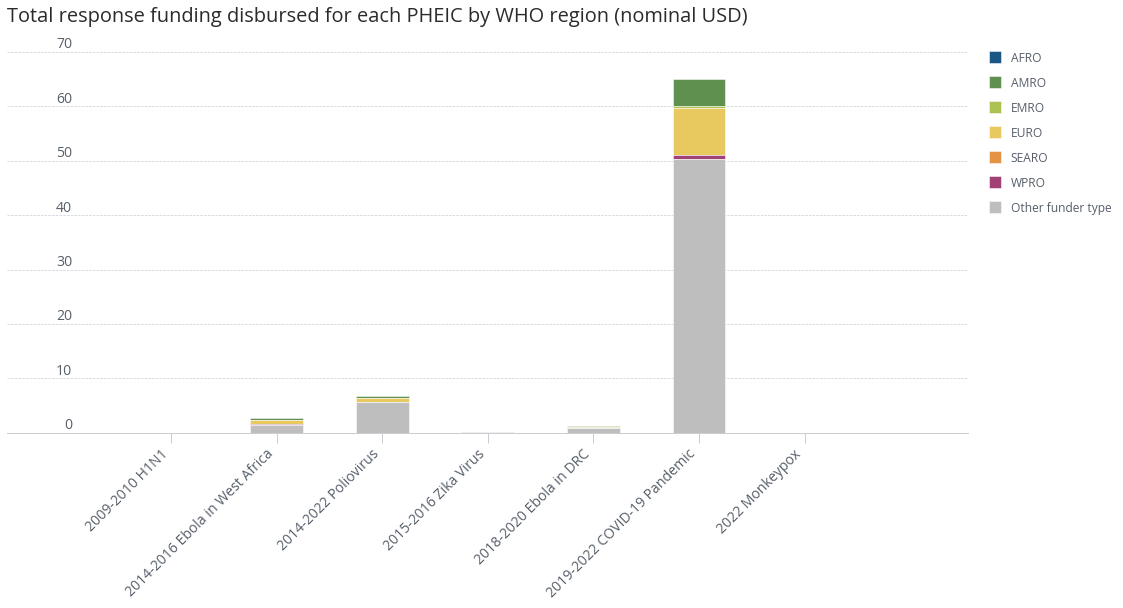

In [987]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['PHEIC Name']
y1=pivot['afro']
y2=pivot['amro']
y3=pivot['emro']
y4=pivot['euro']
y5=pivot['searo']
y6=pivot['wpro']
y7=pivot["Other"]

bar_width=0.5

plt.bar(x, y1, bottom=y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='AFRO')
plt.bar(x, y2, bottom=y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='AMRO')
plt.bar(x, y3, bottom=y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='EMRO')
plt.bar(x, y4, bottom=y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='EURO')
plt.bar(x, y5, bottom=y7+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='SEARO')
plt.bar(x, y6, bottom=y7, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='WPRO')
plt.bar(x, y7, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[10], label='Other funder type')


# Changes y-axis range
plt.gca().set_ybound(0,70e9)

# Set title
title = "Total response funding disbursed for each PHEIC by WHO region (nominal USD)"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y/1e9) if i ==8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-65) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.16,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_by_pheic_by_who_region.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')


#### Relative proportions

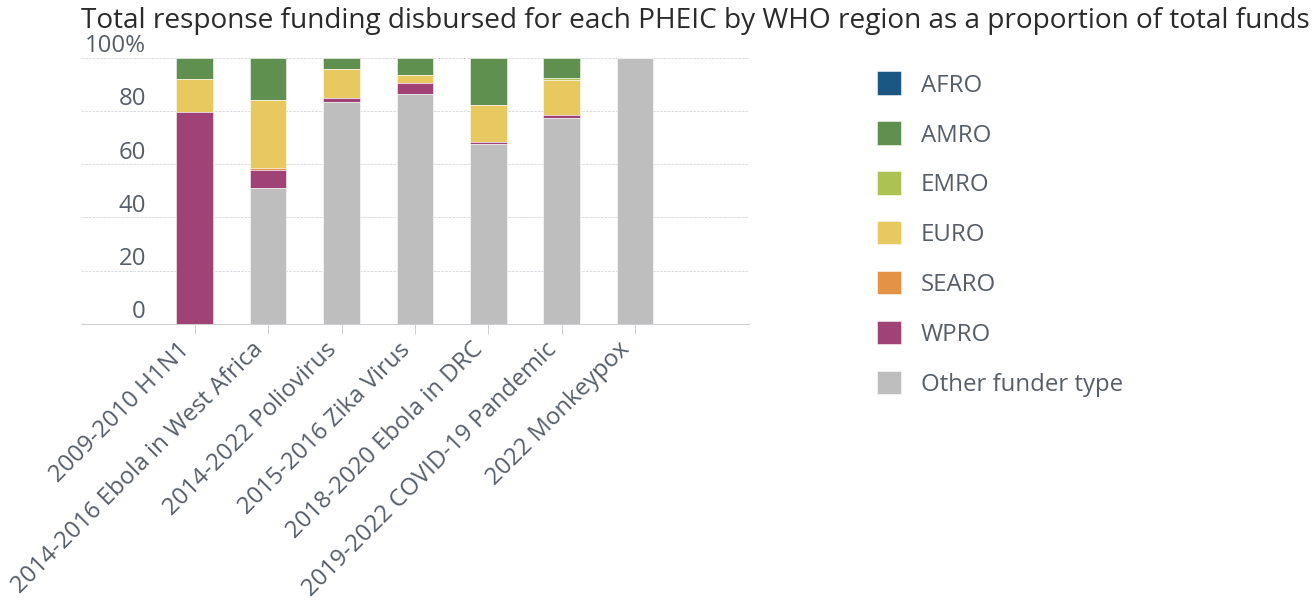

In [225]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['PHEIC Name']
y1=(pivot['afro']/pivot["Total"])*100
y2=(pivot['amro']/pivot["Total"])*100
y3=(pivot['emro']/pivot["Total"])*100
y4=(pivot['euro']/pivot["Total"])*100
y5=(pivot['searo']/pivot["Total"])*100
y6=(pivot['wpro']/pivot["Total"])*100
y7=(pivot["Other"]/pivot["Total"])*100

bar_width=0.5

plt.bar(x, y1, bottom=y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='AFRO')
plt.bar(x, y2, bottom=y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='AMRO')
plt.bar(x, y3, bottom=y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='EMRO')
plt.bar(x, y4, bottom=y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='EURO')
plt.bar(x, y5, bottom=y7+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='SEARO')
plt.bar(x, y6, bottom=y7, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='WPRO')
plt.bar(x, y7, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[10], label='Other funder type')


# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Total response funding disbursed for each PHEIC by WHO region as a proportion of total funds"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if y ==100 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-65) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.16,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/relative_disbursed_by_pheic_by_who_region.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')


### Funding received

#### Transform

In [226]:
pivot = region.pivot_table(index="PHEIC Name", columns='Recipient WHO', values='Total Disbursed to Recipient', aggfunc='sum', fill_value=0).reset_index()
pivot['Total'] = pivot.sum(axis=1,numeric_only=True)
pivot.head()

Recipient WHO,PHEIC Name,Other,afro,amro,emro,euro,searo,wpro,Total
0,2009-2010 H1N1,2.096208e+07,0.000000e+00,1.889878e+06,0.000000e+00,0.000000e+00,3.998100e+05,0.000000e+00,2.325176e+07
1,2014-2016 Ebola in West Africa,7.463647e+08,1.994105e+09,5.000140e+05,8.818997e+06,7.560915e+05,0.000000e+00,9.241750e+05,2.751469e+09
2,2014-2022 Poliovirus,2.080323e+09,2.223609e+09,3.032666e+07,1.954349e+09,4.233603e+07,3.777037e+08,5.708991e+07,6.765737e+09
3,2015-2016 Zika Virus,6.084391e+07,0.000000e+00,1.528450e+08,0.000000e+00,2.281892e+04,2.938466e+06,2.627209e+06,2.192774e+08
4,2018-2020 Ebola in DRC,2.744742e+08,1.032868e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.307342e+09


#### Stacked bar chart

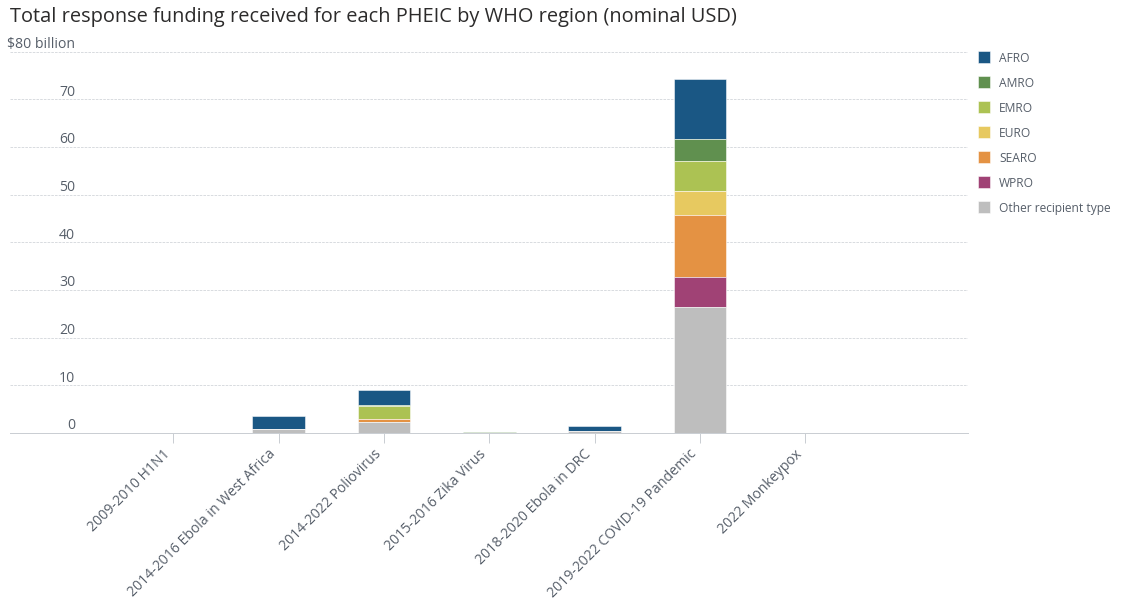

In [770]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['PHEIC Name']
y1=pivot['afro']
y2=pivot['amro']
y3=pivot['emro']
y4=pivot['euro']
y5=pivot['searo']
y6=pivot['wpro']
y7=pivot["Other"]

bar_width=0.5

plt.bar(x, y1, bottom=y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='AFRO')
plt.bar(x, y2, bottom=y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='AMRO')
plt.bar(x, y3, bottom=y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='EMRO')
plt.bar(x, y4, bottom=y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='EURO')
plt.bar(x, y5, bottom=y7+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='SEARO')
plt.bar(x, y6, bottom=y7, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='WPRO')
plt.bar(x, y7, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[10], label='Other recipient type')


# Changes y-axis range
plt.gca().set_ybound(0,80e9)

# Set title
title = "Total response funding received for each PHEIC by WHO region (nominal USD)"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y/1e9) if i ==8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-65) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.16,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# # plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/received_by_pheic_by_who_region.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')


#### Relative proportions

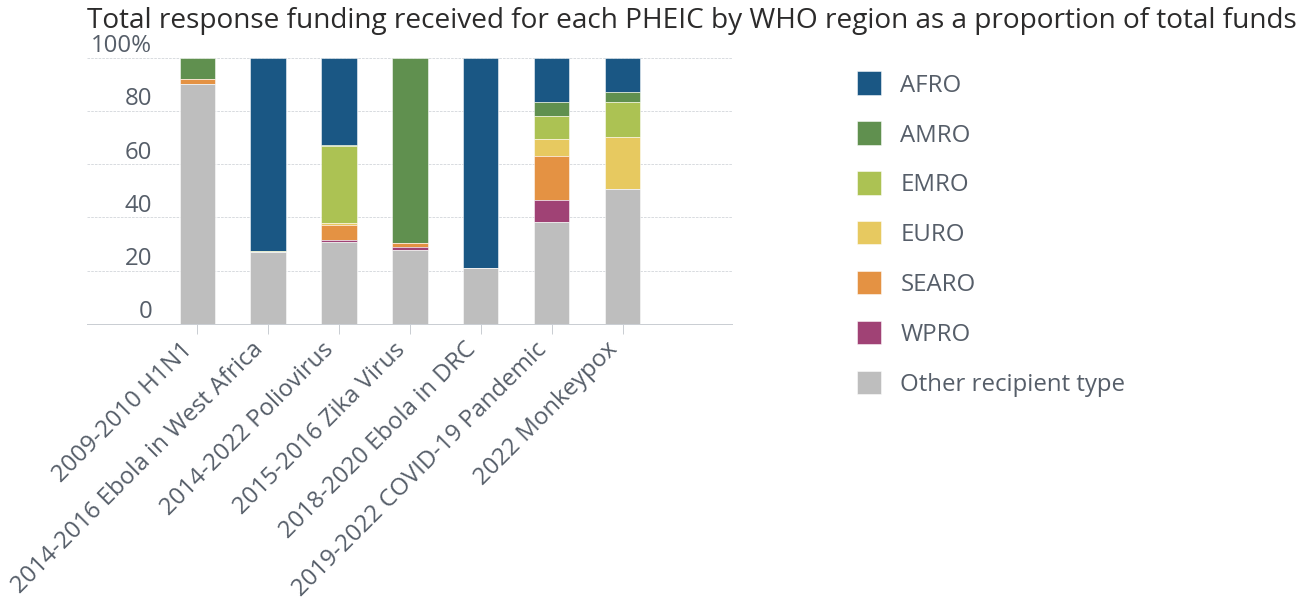

In [227]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['PHEIC Name']
y1=(pivot['afro']/pivot["Total"]*100)
y2=(pivot['amro']/pivot["Total"]*100)
y3=(pivot['emro']/pivot["Total"]*100)
y4=(pivot['euro']/pivot["Total"]*100)
y5=(pivot['searo']/pivot["Total"]*100)
y6=(pivot['wpro']/pivot["Total"]*100)
y7=(pivot["Other"]/pivot["Total"]*100)

bar_width=0.5

plt.bar(x, y1, bottom=y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='AFRO')
plt.bar(x, y2, bottom=y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='AMRO')
plt.bar(x, y3, bottom=y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='EMRO')
plt.bar(x, y4, bottom=y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='EURO')
plt.bar(x, y5, bottom=y7+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='SEARO')
plt.bar(x, y6, bottom=y7, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='WPRO')
plt.bar(x, y7, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[10], label='Other recipient type')


# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Total response funding received for each PHEIC by WHO region as a proportion of total funds"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if y ==100 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-65) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.16,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# # plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/relative_received_by_pheic_by_who_region.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')


#### COVID Specific

In [228]:
region.head()

,Funder Name,Funder WHO,Recipient Name,Recipient WHO,PHEIC Name,Year,Total Disbursed to Recipient,Date
0,Global Alliance for Vaccines and Immunisation ...,Other,Low and middle-income countries (LMIC),Other,2019-2022 COVID-19 Pandemic,2021,6.380965e+09,2021-01-01
1,United States of America,amro,Low and middle-income countries (LMIC),Other,2019-2022 COVID-19 Pandemic,2021,4.000009e+09,2021-01-01
2,United States Agency for International Develop...,Other,Low and middle-income countries (LMIC),Other,2019-2022 COVID-19 Pandemic,2021,4.000000e+09,2021-01-01
3,Asian Development Bank,Other,Indonesia,searo,2019-2022 COVID-19 Pandemic,2020,1.540552e+09,2020-01-01
4,Asian Development Bank,Other,India,searo,2019-2022 COVID-19 Pandemic,2020,1.500000e+09,2020-01-01


In [229]:
cov = region[region["PHEIC Name"]=="2019-2022 COVID-19 Pandemic"]
cov = cov[cov["Year"]>=2020]
cov = cov[cov["Year"]<=2022]
cov = cov.groupby(['Date','Recipient WHO']).sum("Total Disbursed to Recipient").reset_index()
cov = cov[cov["Recipient WHO"]!="Other"]

In [230]:
pivot = cov.pivot_table(index="Date", columns='Recipient WHO', values='Total Disbursed to Recipient', aggfunc='sum', fill_value=0).reset_index()
pivot['Total'] = pivot.sum(axis=1,numeric_only=True)
pivot.head()

Recipient WHO,Date,afro,amro,emro,euro,searo,wpro,Total
0,2020-01-01,5.435100e+09,1.103710e+09,2.503797e+09,2.413201e+09,4.778709e+09,2.261356e+09,1.849587e+10
1,2021-01-01,4.184443e+09,2.073742e+09,2.099861e+09,1.402245e+09,4.470995e+09,2.690029e+09,1.692131e+10
2,2022-01-01,1.108166e+09,2.559342e+08,9.870085e+08,3.065749e+08,1.493180e+09,6.042782e+08,4.755141e+09


In [231]:
print("AFRO:" + str(y1))
print("AMRO:" + str(y2))
print("EMRO:" + str(y3))
print("EURO:" + str(y4))
print("SEARO:" + str(y5))
print("WPRO:" + str(y6))

AFRO:0     0.000000
1    72.474193
2    32.865727
3     0.000000
4    79.005170
5    16.498653
6    12.673597
dtype: float64
AMRO:0     8.127889
1     0.018173
2     0.448239
3    69.703941
4     0.000000
5     5.279861
6     3.802079
dtype: float64
EMRO:0     0.000000
1     0.320520
2    28.885980
3     0.000000
4     0.000000
5     8.598720
6    13.411971
dtype: float64
EURO:0     0.000000
1     0.027480
2     0.625742
3     0.010406
4     0.000000
5     6.338842
6    19.396113
dtype: float64
SEARO:0     1.719482
1     0.000000
2     5.582595
3     1.340068
4     0.000000
5    16.546748
6     0.000000
dtype: float64
WPRO:0    0.000000
1    0.033588
2    0.843809
3    1.198121
4    0.000000
5    8.543496
6    0.000000
dtype: float64


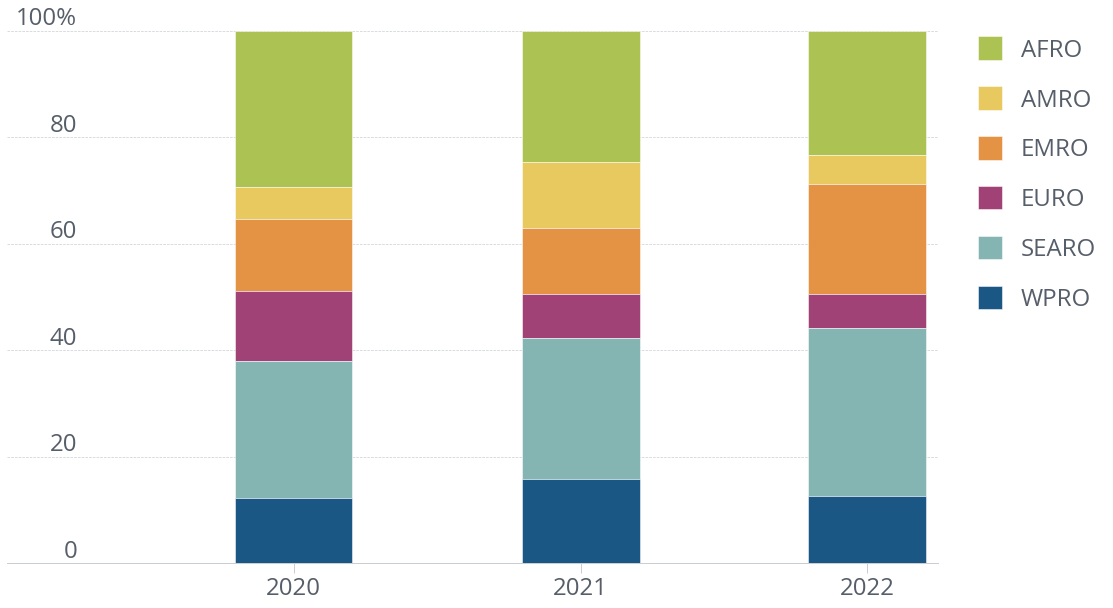

In [234]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['Date']
y1=(pivot['afro']/pivot['Total'])*100 
y2=(pivot['amro']/pivot['Total'])*100 
y3=(pivot['emro']/pivot['Total'])*100 
y4=(pivot['euro']/pivot['Total'])*100 
y5=(pivot['searo']/pivot['Total'])*100 
y6 = (pivot['wpro']/pivot['Total'])*100 


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='AFRO')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='AMRO')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='EMRO')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='EURO')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='SEARO')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='WPRO')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2019,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = ""
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Set major locator for x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))

# Format the x-axis date labels
plt.xticks(ticks=x, labels=["2020","2021","2022"],rotation=0, ha="center")
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if y == 100 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/who_recipient_covid_2020-22_bigleg.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

## 8. How many projects were funded globally?

### Clean

In [793]:
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Flows by funder, core capacity, recipient, and year/results/Flows with project IDs.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

df = df.groupby(['Project ID','Year','Date','Funder Name','Recipient Name']).sum('Total Disbursed to Recipient').reset_index()
df.drop_duplicates(subset=["Total Disbursed to Recipient", "Recipient Name"], keep="first", inplace=True)

# Show data
df.head()

,Project ID,Year,Date,Funder Name,Recipient Name,Total Disbursed to Recipient
0,4295550,2022,2022-01-01,United Nations (UN),Afghanistan,5.302196e+04
2,4295551,2022,2022-01-01,United Nations (UN),Afghanistan,1.051317e+06
4,4295552,2022,2022-01-01,United Nations (UN),Afghanistan,5.451487e+04
6,4295553,2022,2022-01-01,United Nations (UN),Afghanistan,3.315058e+06
8,4295554,2022,2022-01-01,United Nations (UN),Afghanistan,0.000000e+00


### Scatter plot

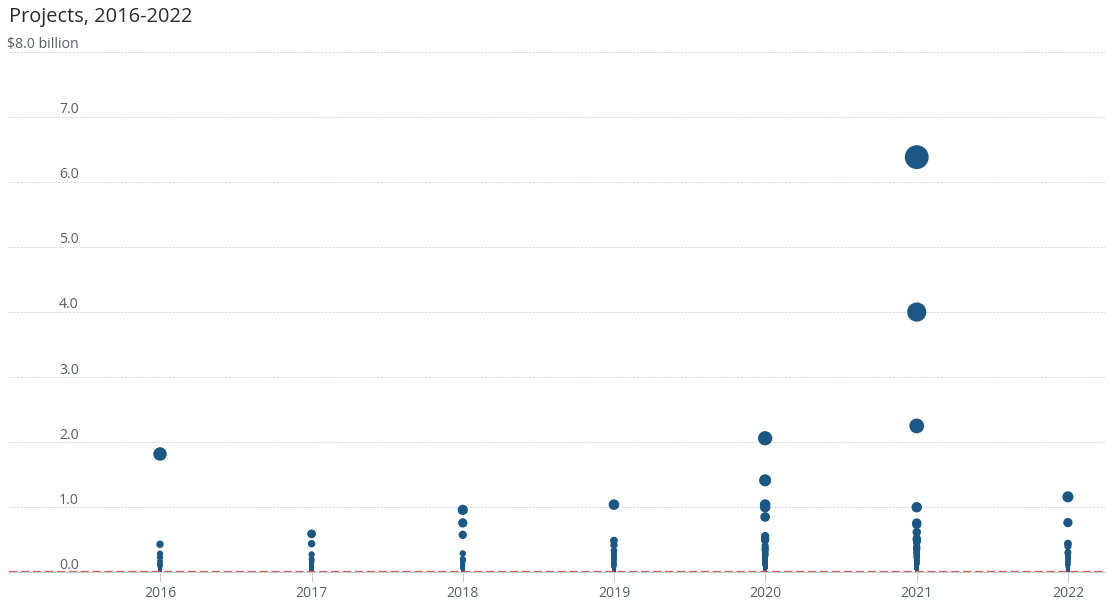

In [808]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=df["Date"]
y=df["Total Disbursed to Recipient"]
s = df["Total Disbursed to Recipient"]

# Define the minimum and maximum size values
min_size = 1  # Adjust this value as needed
max_size = 500

# Scale the size values to be between min_size and max_size
scaled_sizes = np.interp(s, (min(s), max(s)), (min_size, max_size))

plt.scatter(x, y, c=colors[0], s=scaled_sizes)

average_value = df["Total Disbursed to Recipient"].mean()

# Plot the trend line
plt.axhline(y=average_value, color=colors[7], linestyle='--', label='Average Value')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,8e9)

# Set title
title = "Projects, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.1f} billion'.format(y / 1e9) if i == 8 else '{:,.1f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


plt.tight_layout(pad = 1.5)
plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/afro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')